# Intro:
This project aims at studying Order Cancellation tendencies for orders made in the travel industry to help predict order importance and find patterns in customer behaviour.

### Methodology:
We followed a systematic method of tackling the problem by:
- Studying the Domain
- Asking Questions
- Pulling Data
  - From an SQL Database
- Data Pre-Proccessing
  - Adding columns (Ex: is_internal)
- Data Cleaning
- Data Distortion
- EDA
- Drawing Initial Conclusions
- Machinge Learning
- Asking More Questions
- Data Post-Proccessing
  - Adding more columns (Ex: Room_Nights, Review_Rating)
- More Machine Learning
- Final Conclusion

# Dataset:
We used a distorted subset of data acquired from a local business in the travel industry


## Description of Variables
The dataset contains 4238 observations of 21 variables:

### Features:

#### Pre-Processing:
1. Categoral Data:
 - guest_country_code:  
 Contains the country code of the source country of the order
 - destinationCountry:  
 Contains the destination code of the source country of the order
 - udid:                
 Contains customer udid
 - email:               
 Customer email address
 - phone:               
 Customer phone number
 - stars:               
 Specifies the properties' star rating (1->5)
 - hotel_id:            
 Hotel ID        
 - AvgUserRating:       
 Average user ratings for previous guests
 - type:                
 Property type
 - is_cardless:         
 Specifies if the payment method was "Cardless" or not (Boolean)
 - hasSpecialRequest:   
 Shows if the booking has a special request attached to it (Boolean) 
 - hasFreeCancellation: If booking has free cancellation option
 
 2. Non-Categoral:
  - roomCount:                   Total booking number of rooms
  - numberOfBookedNights:        Number of nights the booking has
  - numberOfReviews:             Amount of people that reviewed the property
  - NormalizedLowRate:           Price of the lowest room available at the property at the time of the booking
  - NormalizedTotalBookingPrice: Total booking price
  
#### Post-Processing:
 - Room_Nights:   numberOfBookedNights * roomCount
 - Review_Rating: AvgUserRating *  numberOfReviews
 - is_internal:   Shows if the booking was made from the same source and destination countries (Boolean)

 
### Target:
- cancelledOrNoShow: If the order was cancelled (or customer didn't show up) (Boolean)

## Importing the Packages

In [0]:
import math
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib.pyplot import pie, axis, show
from matplotlib import pyplot as plt
from matplotlib import cm as cm
%matplotlib inline


import sklearn
from sklearn.linear_model import LinearRegression
from sklearn import svm

import missingno as msno



# Reading the Data:

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/novaaky/Machine-Learning-for-Hospitality/master/Order-Cancellation-Prediction/distorted_data_extra_field.csv', sep=',')

## Data Preprocessing:
### Remove unneeded column

In [6]:
len(df)

4238

In [0]:
df.drop(df.columns[[0]], axis=1, inplace=True)

In [8]:
df.columns

Index(['destinationCountry', 'roomCount', 'udid', 'email', 'phone',
       'guest_country_code', 'is_cardless', 'stars', 'type',
       'NormalizedTotalBookingPrice', 'NormalizedLowRate',
       'numberOfBookedNights', 'numberOfReviews', 'AvgUserRating', 'hotel_id',
       'hasSpecialRequest', 'hasFreeCancellation', 'cancelledOrNoShow',
       'is_internal'],
      dtype='object')

In [9]:
df.head()

,destinationCountry,roomCount,udid,email,phone,guest_country_code,is_cardless,stars,type,NormalizedTotalBookingPrice,NormalizedLowRate,numberOfBookedNights,numberOfReviews,AvgUserRating,hotel_id,hasSpecialRequest,hasFreeCancellation,cancelledOrNoShow,is_internal
0,0,1.0,0,0,0,0,0,4.0,HOTEL,229.0,166.0,1,103.0,3.9643,0,0,1,0,1
1,1,2.0,1,1,1,0,0,1.0,HOTEL,126.0,90.0,2,10.0,1.0000,1,0,0,1,0
2,2,1.0,2,2,2,0,0,5.0,HOTEL,1722.0,753.0,4,25.0,3.8000,2,1,0,1,0
3,0,1.0,3,3,3,1,0,3.5,UNKNOWN,685.0,373.0,2,16.0,3.6000,3,0,0,0,0
4,2,1.0,0,4,4,2,0,5.0,HOTEL,427.0,401.0,1,10.0,5.0000,4,0,0,0,1


In [10]:
len(df)

4238

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
destinationCountry,4238.0,5.357480,7.891933,0.0,0.0000,2.000,8.0000,57.0
roomCount,4238.0,1.221095,0.635255,0.0,1.0000,1.000,1.0000,13.0
udid,4238.0,862.870694,862.418205,0.0,0.0000,640.500,1602.7500,2625.0
email,4238.0,1453.201982,1079.400480,0.0,440.2500,1387.500,2391.7500,3425.0
phone,4238.0,1934.479471,1151.241212,0.0,926.2500,1908.500,2927.7500,3971.0
guest_country_code,4238.0,3.039169,6.078425,0.0,0.0000,0.000,3.0000,50.0
is_cardless,4238.0,0.100047,0.300098,0.0,0.0000,0.000,0.0000,1.0
stars,4238.0,3.569962,1.413505,0.0,3.0000,4.000,4.5000,5.0
NormalizedTotalBookingPrice,4238.0,23992.322794,482250.391588,77.0,326.0000,713.000,1648.7500,25700521.0
NormalizedLowRate,4238.0,7123.140396,97182.274956,77.0,203.0000,373.000,615.0000,2655754.0


In [12]:
#Number of orders that have null values
df.isnull().values.sum()

0

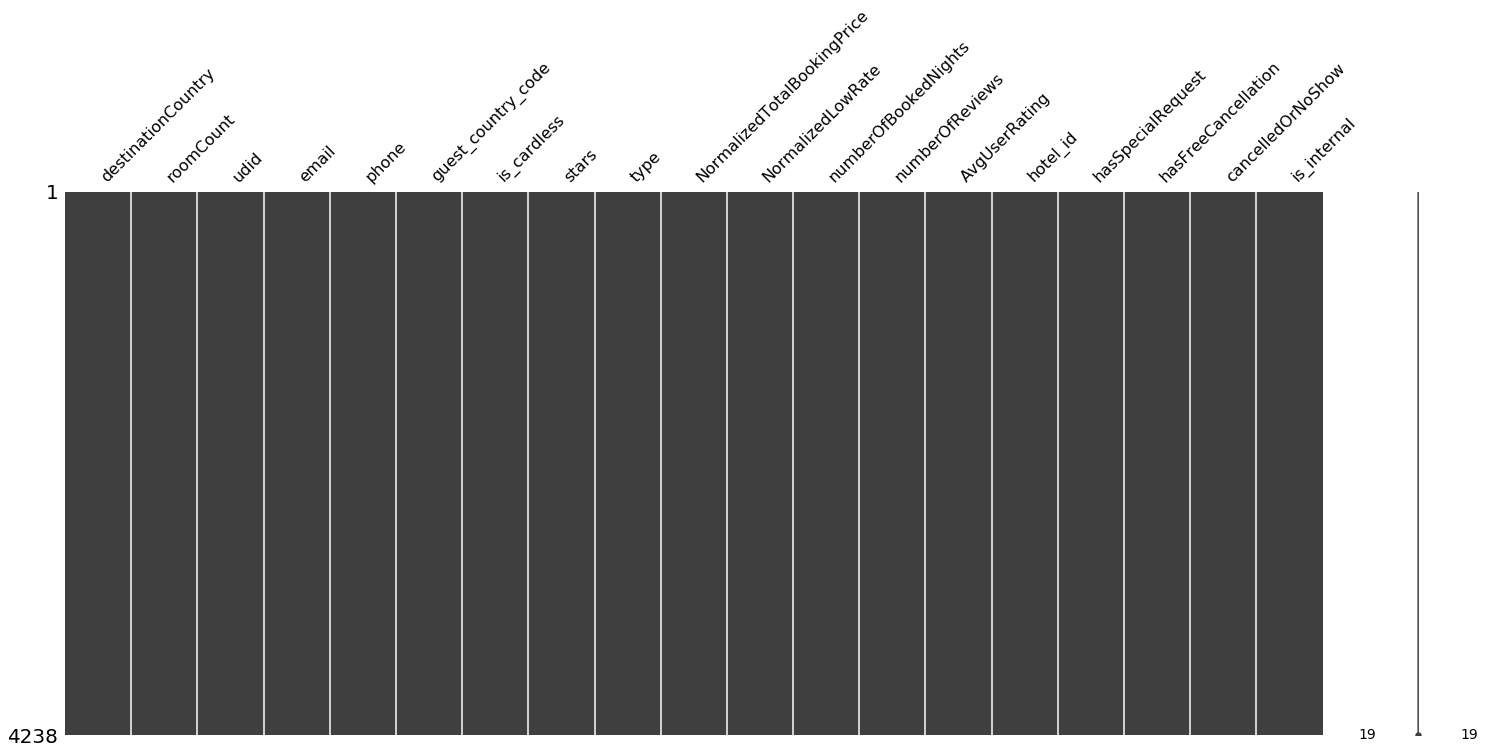

In [13]:
msno.matrix(df)

In [0]:
# Incrimenting ID values (to avoid keeping them as zeros)
def fillNA(data):
    data = np.array(data)
    toFloat = [float(floatValue) for floatValue in data]       #Convert to float
    biggestId = np.max(toFloat)                                #Find biggest id available (to avoid overlapping)
    print("Max id number available =", biggestId)
    
    for i in range (len(data)):
        if float(data[i]) == 0:
            data[i] = biggestId   
            biggestId = biggestId +1                           #Increment ID value
    return data

In [15]:
#Fill UDID missing data with correct values
udid = fillNA(df['udid'])
#df['udid'] = udid

Max id number available = 2625.0


In [0]:
#Check number of missing values after cleaning
df.fillna(0, inplace=True)

## Look for anomalies in the data

In [17]:
nullRooms         = df.loc[df['roomCount']            <= 0 ]
noReviews         = df.loc[df['numberOfReviews']      <= 0 ]
noNights          = df.loc[df['numberOfBookedNights'] <= 0 ]
noNights          = df.loc[df['numberOfBookedNights'] <= 0 ]
avgRating         = df.loc[df['AvgUserRating']        == 0 ]


print("Number of hotels with no reviews =",len(noReviews))
print("\nNumber of orders with no nights  =",len(noNights))
print('Number of orders with no rooms   =', len(nullRooms))


nullRooms.head()

Number of hotels with no reviews = 0

Number of orders with no nights  = 0
Number of orders with no rooms   = 3


,destinationCountry,roomCount,udid,email,phone,guest_country_code,is_cardless,stars,type,NormalizedTotalBookingPrice,NormalizedLowRate,numberOfBookedNights,numberOfReviews,AvgUserRating,hotel_id,hasSpecialRequest,hasFreeCancellation,cancelledOrNoShow,is_internal
1865,8,0.0,0,1558,1794,0,0,4.0,HOTEL,1059.0,228.0,6,10.0,5.0000,1042,0,0,1,0
2084,2,0.0,1347,1735,1991,0,0,4.0,HOTEL,8795.0,718.0,9,35.0,2.9375,1116,0,0,1,0
2620,10,0.0,0,2179,2495,0,0,5.0,HOTEL,5433.0,1088.0,9,13.0,4.3333,337,0,0,0,0


## Handle data anomalies by removing orders with rooms count = 0

In [0]:
indexes_to_drop = df[df['roomCount'] == 0].index.tolist()
df.drop(df.index[indexes_to_drop], inplace=True)

### Making sure all went well

In [19]:
nullRooms       = df.loc[df['roomCount']       == 0 ]

print('Number of orders with no rooms   =', len(nullRooms))

Number of orders with no rooms   = 0


### Round Average Reviews 

In [20]:
df['AvgUserRating'] = np.round(df['AvgUserRating'], decimals=0)
df['AvgUserRating'].head()

df['stars'] = np.round(df['stars'], decimals=0)
df['stars'][:20]

0     4.0
1     1.0
2     5.0
3     4.0
4     5.0
5     3.0
6     0.0
7     0.0
8     3.0
9     4.0
10    4.0
11    5.0
12    4.0
13    4.0
14    4.0
15    5.0
16    5.0
17    4.0
18    3.0
19    4.0
Name: stars, dtype: float64

## Create Dataframe for cancelled orders

In [21]:
cancelled = df.loc[df['cancelledOrNoShow'] == 1]
print(len(cancelled) / len(df) * 100)

32.585596221959854


In [22]:
print(df.isnull().values.sum())

0


## Add column for Internal Travel vs External Travel

In [0]:
def add_trip_type(df):
    is_internal = []
    count_same =0
    for i in range (len(df)):
        if (df['destinationCountry'][i] == df['guest_country_code'][i]):
            #print("\nSame\nDestination Country=", df['destinationCountry'][i], "\nSource Country     =", df['guest_country_code'][i])
            count_same += 1
            is_internal.append(1)
        else:
            is_internal.append(0)
    print(count_same/len(df) * 100)
    #return is_internal

In [0]:
#add_trip_type(df)

# Check Cancellation Tendency Based on Different Factors

In [25]:
destination = df[['destinationCountry', 'cancelledOrNoShow']].groupby(['destinationCountry'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
destination[:20]

,destinationCountry,cancelledOrNoShow
49,49,1.000000
33,33,0.666667
38,38,0.666667
25,25,0.555556
28,28,0.500000
32,32,0.500000
20,20,0.428571
14,14,0.425000
53,53,0.400000
7,7,0.392857


In [26]:
source = df[['guest_country_code', 'cancelledOrNoShow']].groupby(['guest_country_code'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
source[:20]

,guest_country_code,cancelledOrNoShow
32,32,1.000000
49,49,1.000000
48,48,1.000000
47,47,1.000000
46,46,1.000000
41,41,1.000000
38,38,1.000000
25,25,0.615385
24,24,0.500000
27,27,0.500000


In [27]:
property_type = df[['type', 'cancelledOrNoShow']].groupby(['type'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
property_type[:20]

,type,cancelledOrNoShow
18,YAMSAFER_HOMES,1.000000
12,PENSION,1.000000
6,HOSTEL,1.000000
10,INN,0.571429
7,HOSTEL_BACKPACKER_ACCOMMODATION,0.555556
15,SUITE,0.478261
1,APARTMENT,0.454545
0,ALL_INCLUSIVE,0.416667
13,RESIDENCE,0.375000
17,VILLA,0.352941


In [28]:
reviews_number = df[['AvgUserRating', 'cancelledOrNoShow']].groupby(['AvgUserRating'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
reviews_number

,AvgUserRating,cancelledOrNoShow
3,3.0,0.357955
0,0.0,0.357016
4,4.0,0.306306
1,1.0,0.297297
2,2.0,0.289116
5,5.0,0.251082


In [29]:
property_type = df[['stars', 'cancelledOrNoShow']].groupby(['stars'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
property_type

,stars,cancelledOrNoShow
0,0.0,0.471178
2,2.0,0.372263
1,1.0,0.355556
3,3.0,0.352736
4,4.0,0.316362
5,5.0,0.256925


### 5 Star hotels have the lowest cancellation rate while unrated hotels have the highest rate

In [30]:
property_type = df[['hasSpecialRequest', 'cancelledOrNoShow']].groupby(['hasSpecialRequest'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
property_type

,hasSpecialRequest,cancelledOrNoShow
0,0,0.329802
1,1,0.299639


### Looks like people who have a special request take their bookings more seriously

In [31]:
property_type = df[['hasFreeCancellation', 'cancelledOrNoShow']].groupby(['hasFreeCancellation'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
property_type[:20]

,hasFreeCancellation,cancelledOrNoShow
1,1,0.408644
0,0,0.299658


### Hotels that provide free cancellation are more likely to have their bookings cancelled

In [32]:
property_type = df[['is_internal', 'cancelledOrNoShow']].groupby(['is_internal'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
property_type[:20]

,is_internal,cancelledOrNoShow
1,1,0.345885
0,0,0.310185


### Internal bookings are more likelt to get cancelled than external

In [33]:
property_type = df[['is_cardless', 'cancelledOrNoShow']].groupby(['is_cardless'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
property_type[:20]

,is_cardless,cancelledOrNoShow
1,1,0.471698
0,0,0.309630


### Cardless bookings get cancelled more than other payment methods

In [34]:
property_type = df[['numberOfBookedNights', 'cancelledOrNoShow']].groupby(['numberOfBookedNights'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
property_type[:30]

,numberOfBookedNights,cancelledOrNoShow
30,31,1.000000
23,24,1.000000
28,29,1.000000
21,22,1.000000
29,30,1.000000
19,20,1.000000
18,19,1.000000
26,27,1.000000
16,17,0.666667
12,13,0.666667


In [35]:
property_type = df[['roomCount', 'cancelledOrNoShow']].groupby(['roomCount'], as_index=False).mean().sort_values(by='cancelledOrNoShow', ascending=False)
property_type[:30]

,roomCount,cancelledOrNoShow
8,10.0,1.000000
6,7.0,0.750000
5,6.0,0.666667
7,8.0,0.400000
2,3.0,0.329268
0,1.0,0.328981
1,2.0,0.304940
3,4.0,0.272727
4,5.0,0.142857
9,13.0,0.000000


## Some EDA on Cancelled Data 

In [0]:
cancelled_orders = df.loc[df['cancelledOrNoShow'] == 1]

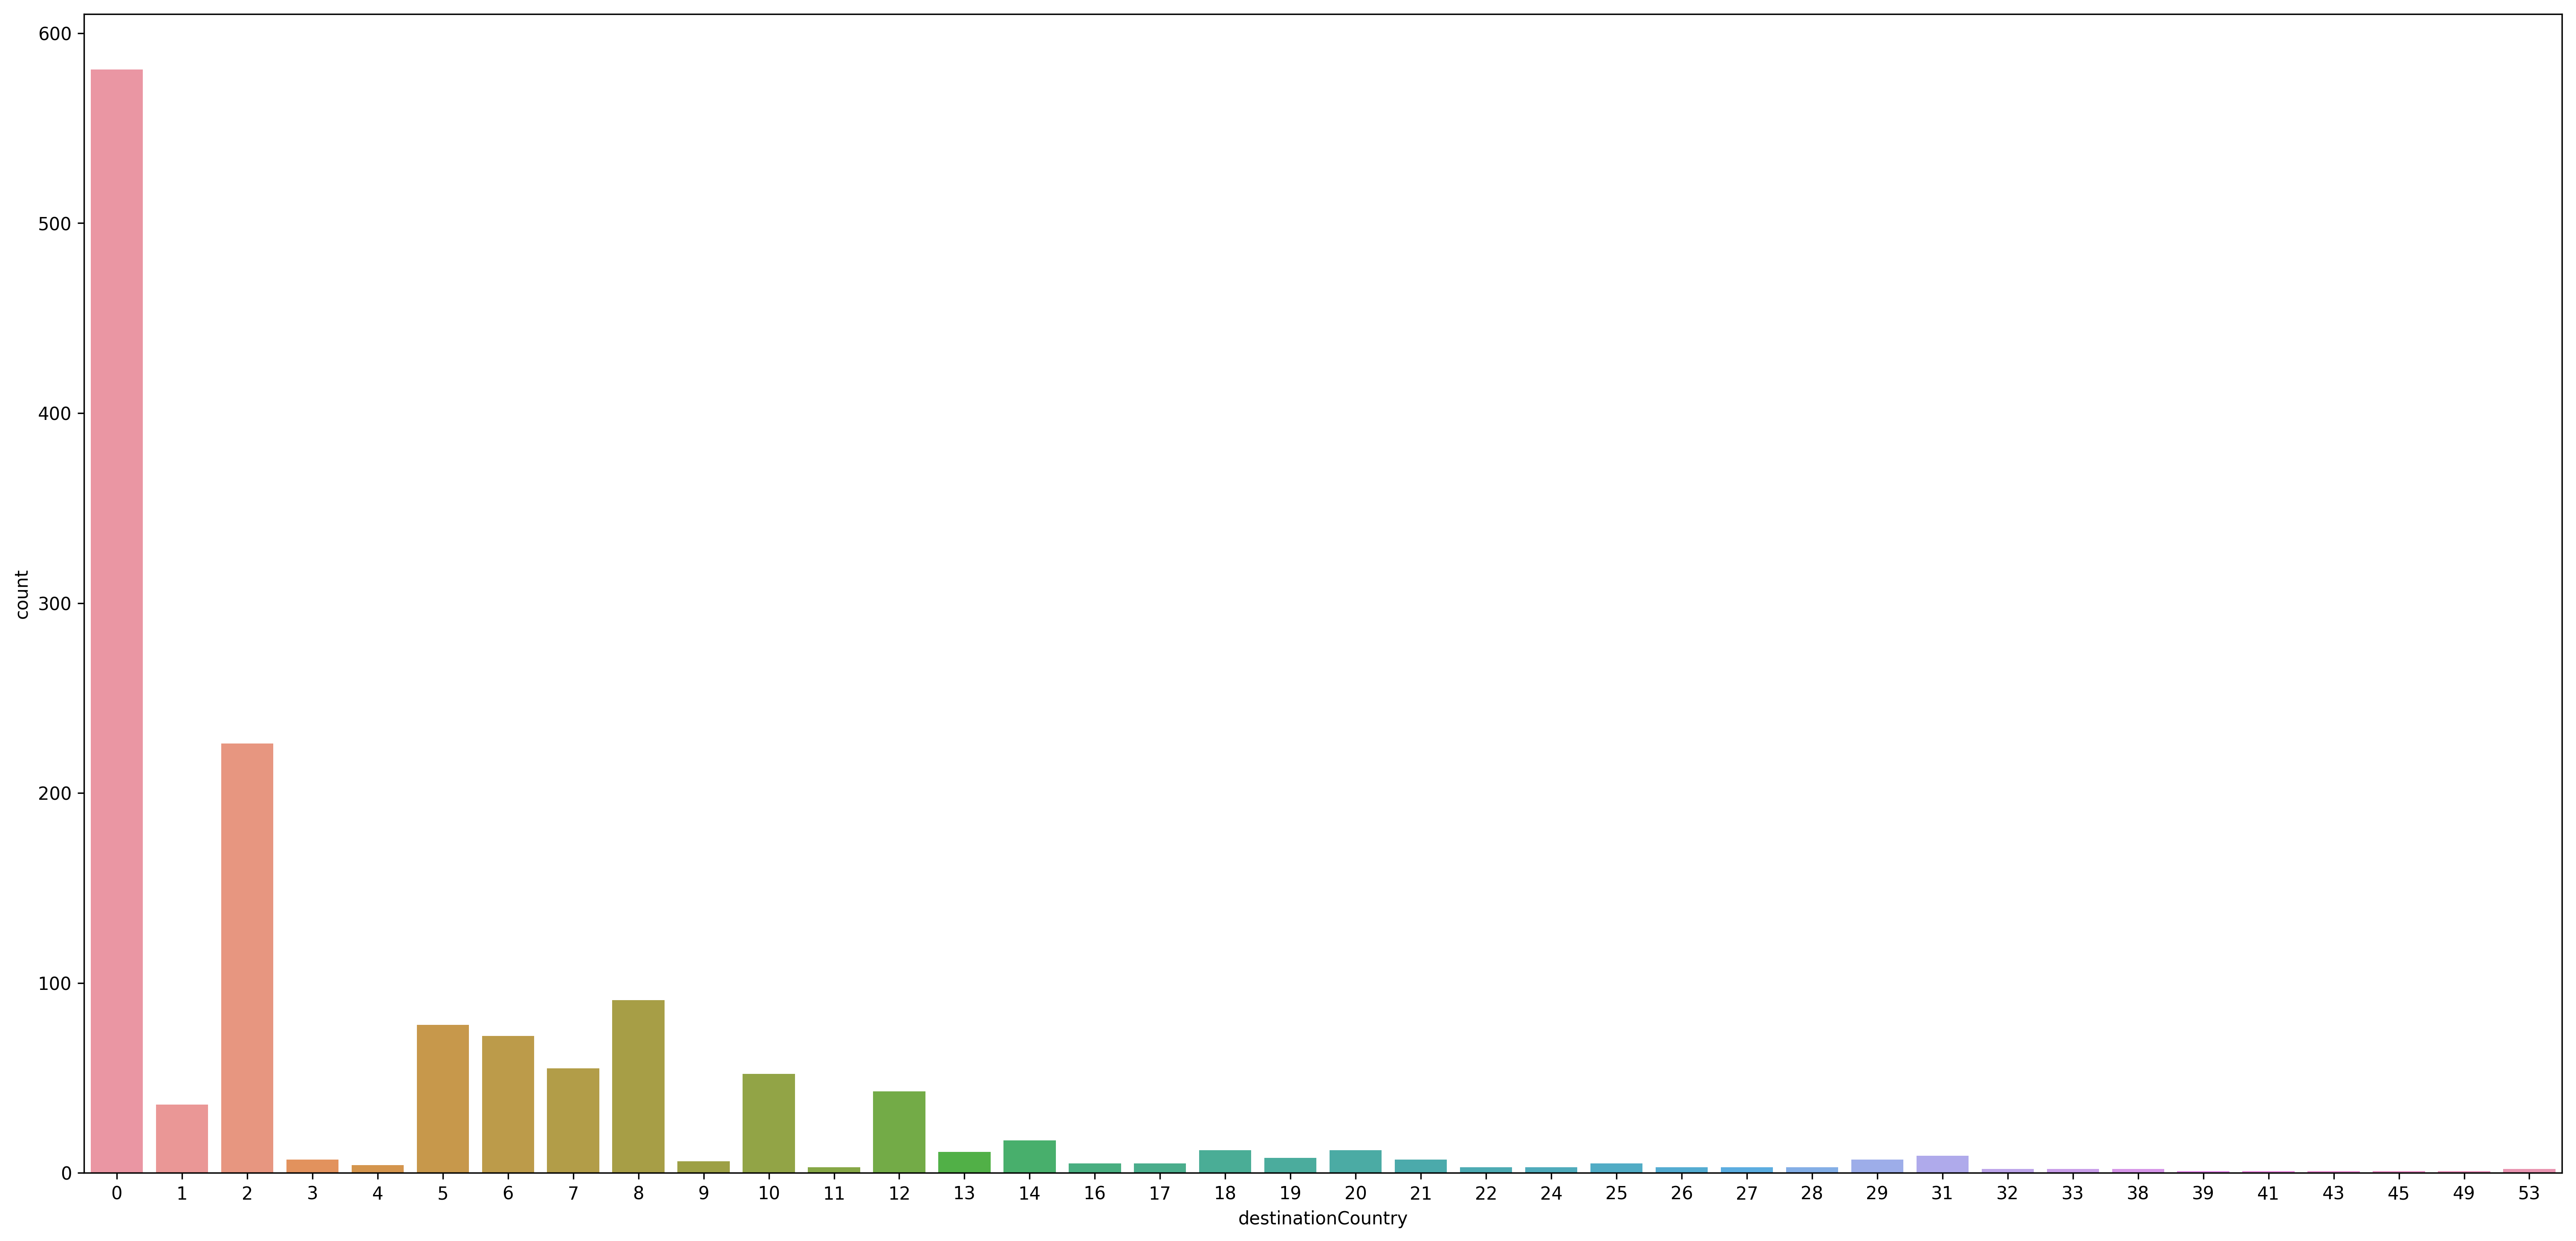

In [37]:
# Plot the number of destination countries for cancelled orders

plt.figure(figsize=(25,12), dpi=300)
p = sns.countplot(x="destinationCountry", data=cancelled_orders)
plt.show()

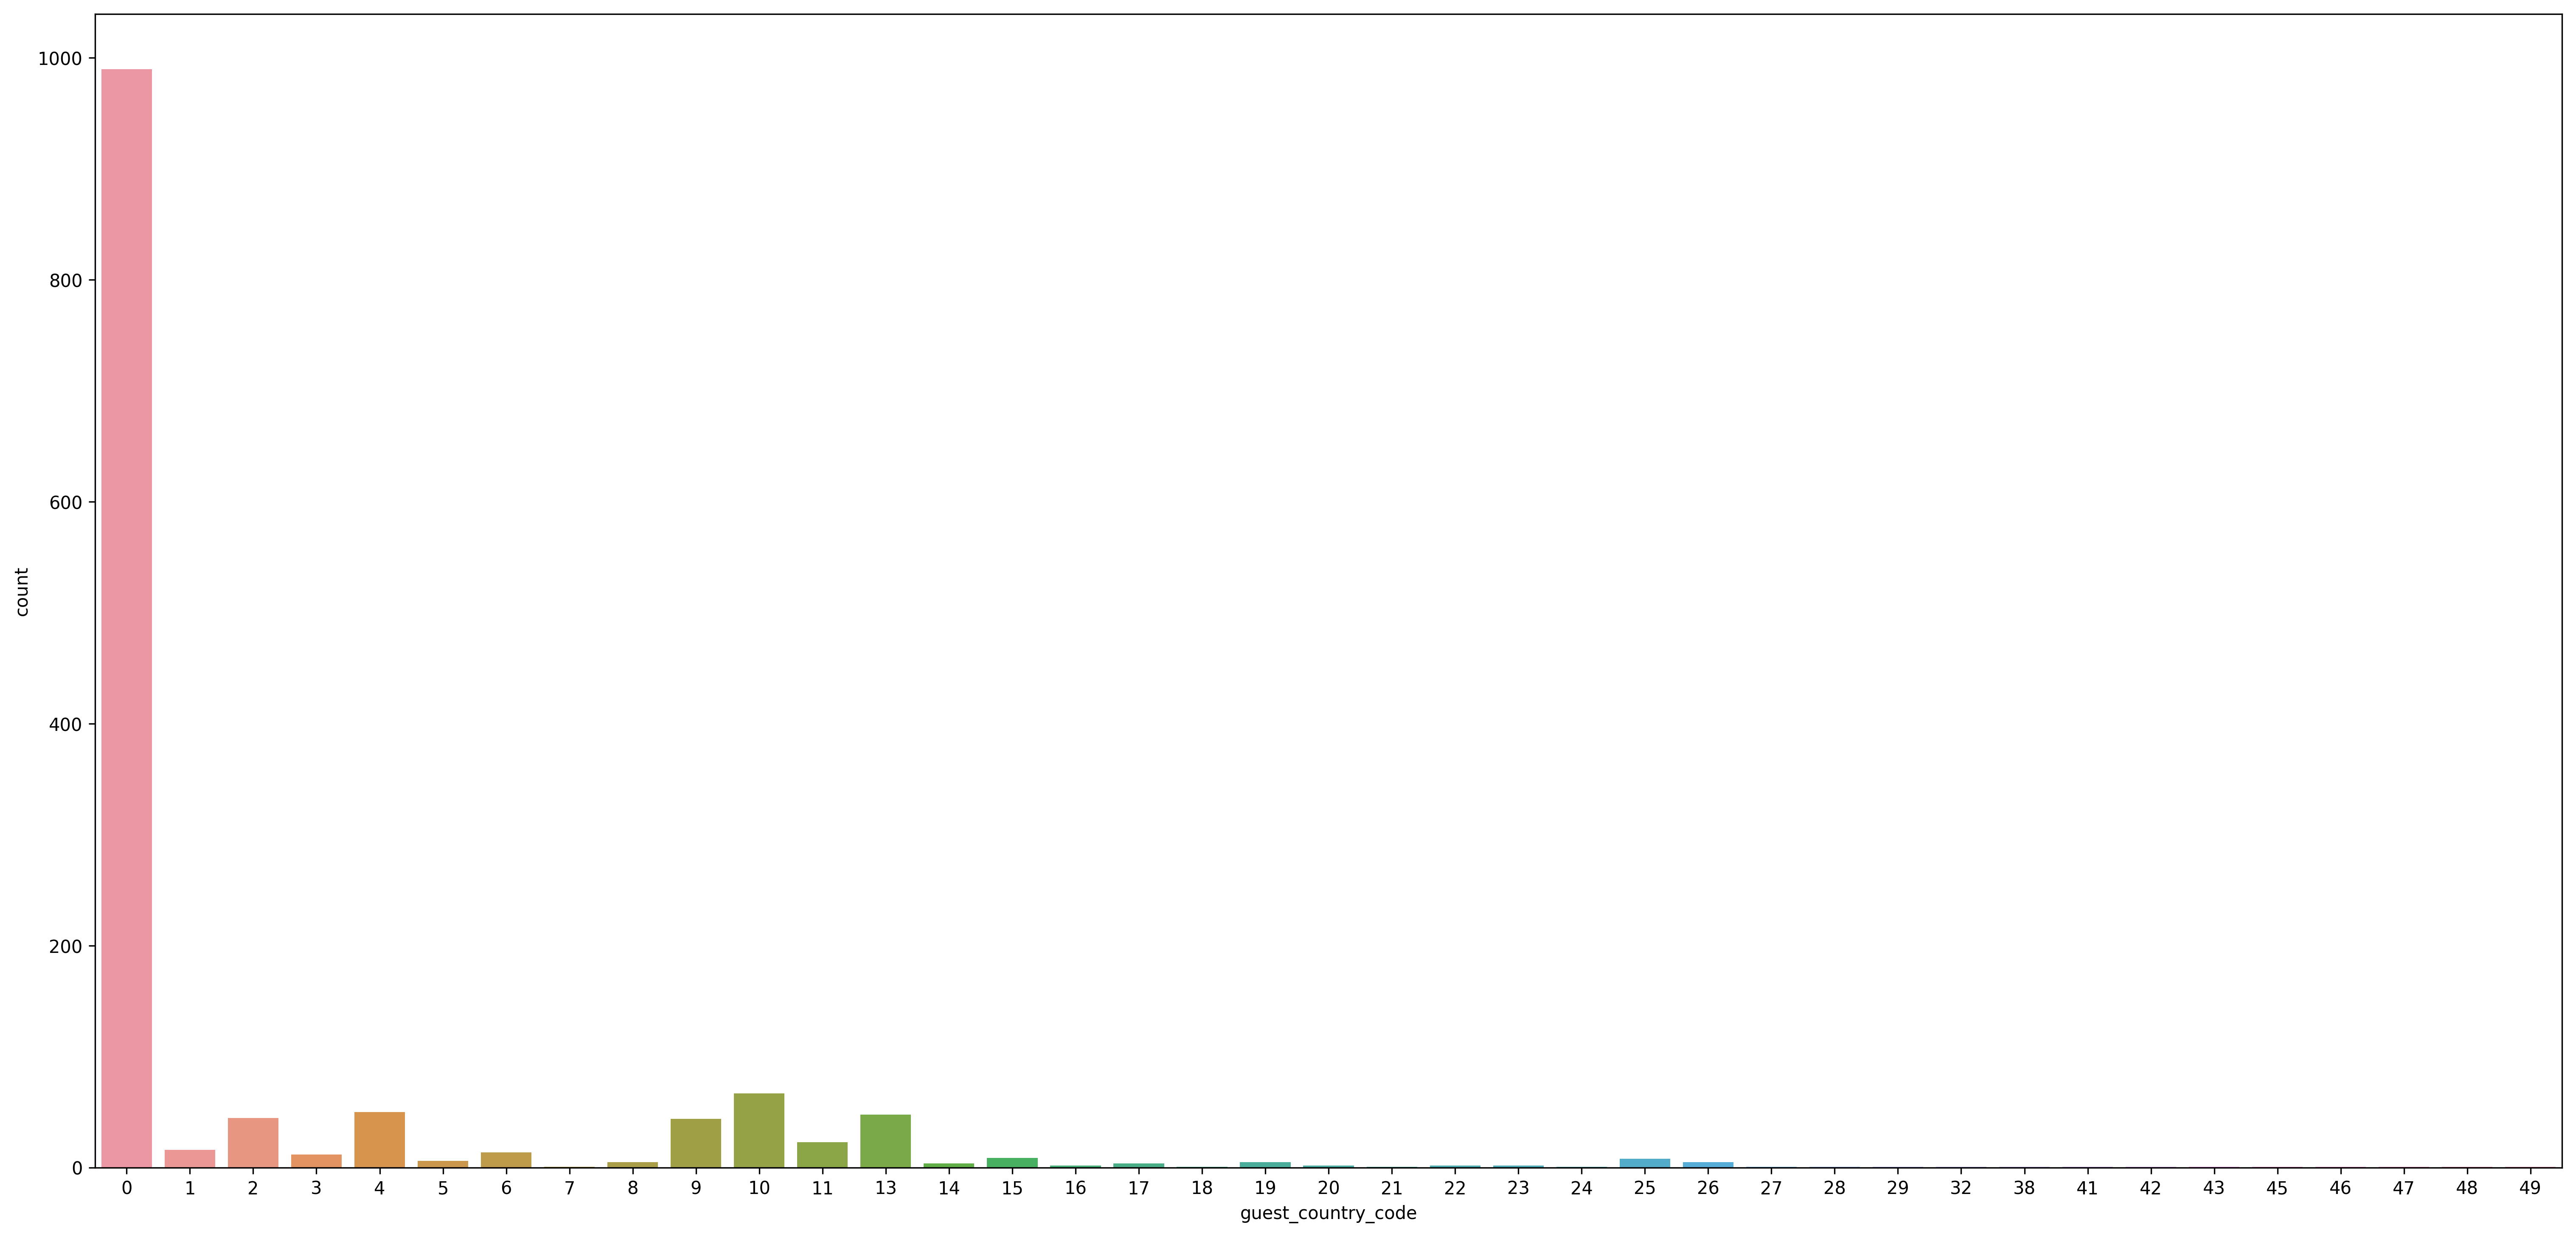

In [38]:
# Plot the number of destination countries for cancelled orders
plt.figure(figsize=(25,12), dpi=300)
p = sns.countplot(x="guest_country_code", data=cancelled_orders)
plt.show()

### ToDo: More EDA !

### Factorizing String values to numbers

In [39]:
df.columns

Index(['destinationCountry', 'roomCount', 'udid', 'email', 'phone',
       'guest_country_code', 'is_cardless', 'stars', 'type',
       'NormalizedTotalBookingPrice', 'NormalizedLowRate',
       'numberOfBookedNights', 'numberOfReviews', 'AvgUserRating', 'hotel_id',
       'hasSpecialRequest', 'hasFreeCancellation', 'cancelledOrNoShow',
       'is_internal'],
      dtype='object')

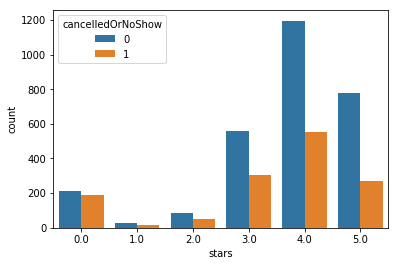

In [40]:
sns.countplot(x='stars', hue='cancelledOrNoShow', data=df)
plt.show()

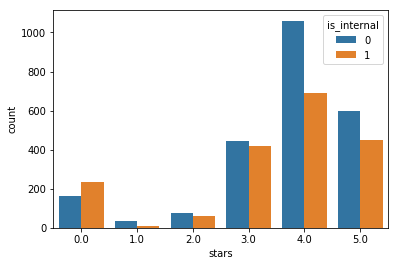

In [41]:
sns.countplot(x='stars', hue='is_internal', data=df)
plt.show()

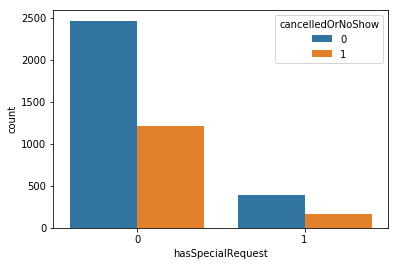

In [42]:
sns.countplot(x='hasSpecialRequest', hue='cancelledOrNoShow', data=df)
plt.show()

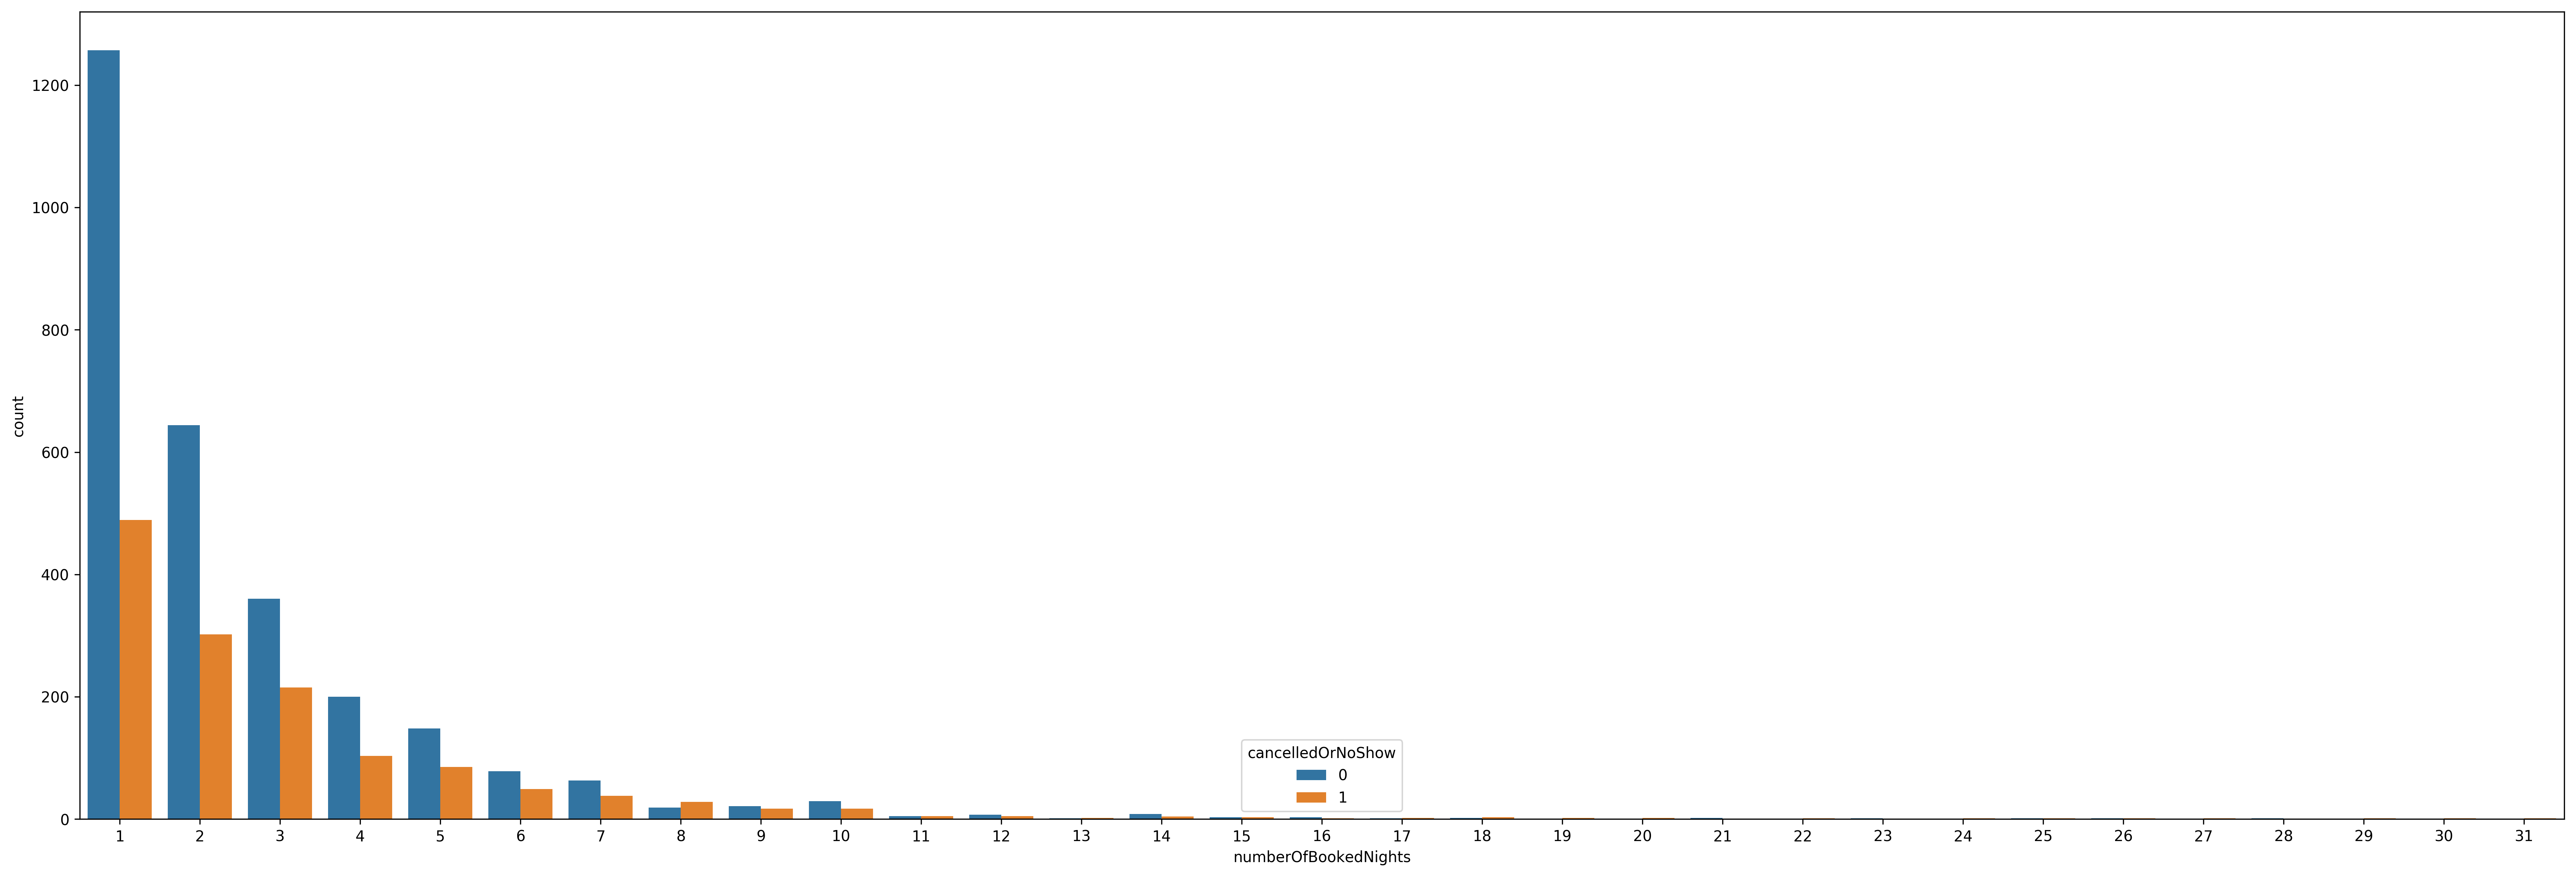

In [43]:
plt.figure(figsize=(30,10), dpi=300)
sns.countplot(x='numberOfBookedNights', hue= 'cancelledOrNoShow', data=df)
plt.show()

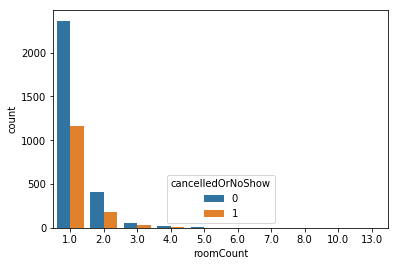

In [44]:
sns.countplot(x='roomCount', hue= 'cancelledOrNoShow', data=df)
plt.show()

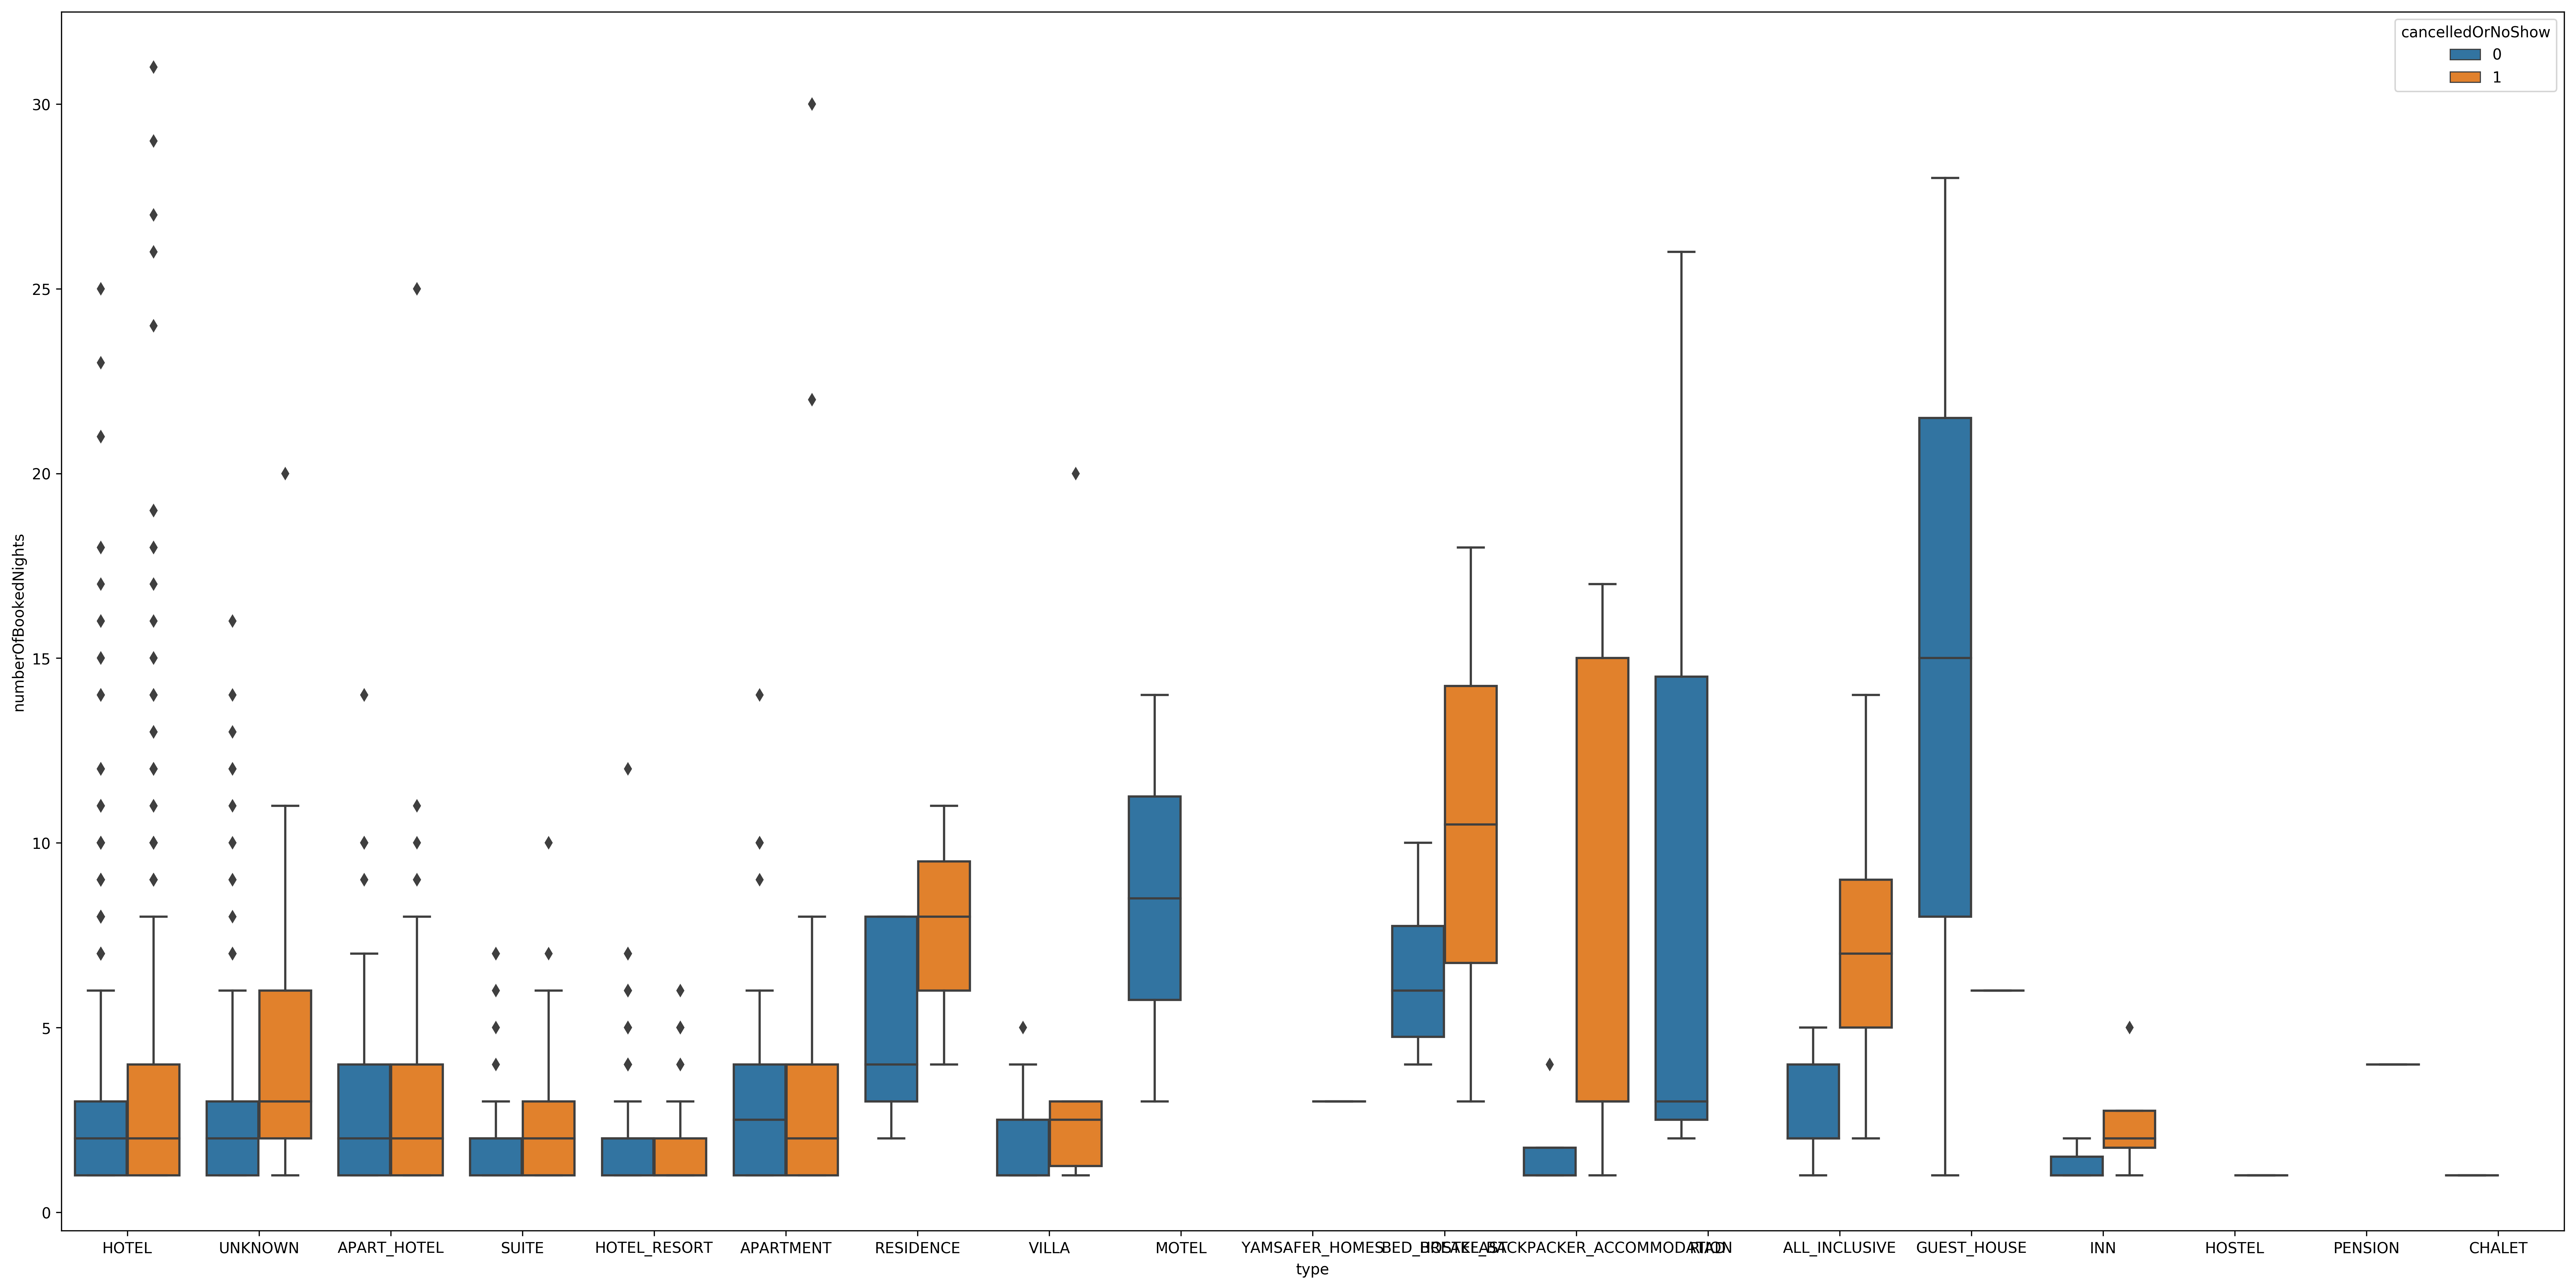

In [45]:
plt.figure(figsize=(30,15), dpi=300)
sns.boxplot(x='type', y='numberOfBookedNights', hue='cancelledOrNoShow', data=df)
plt.show()

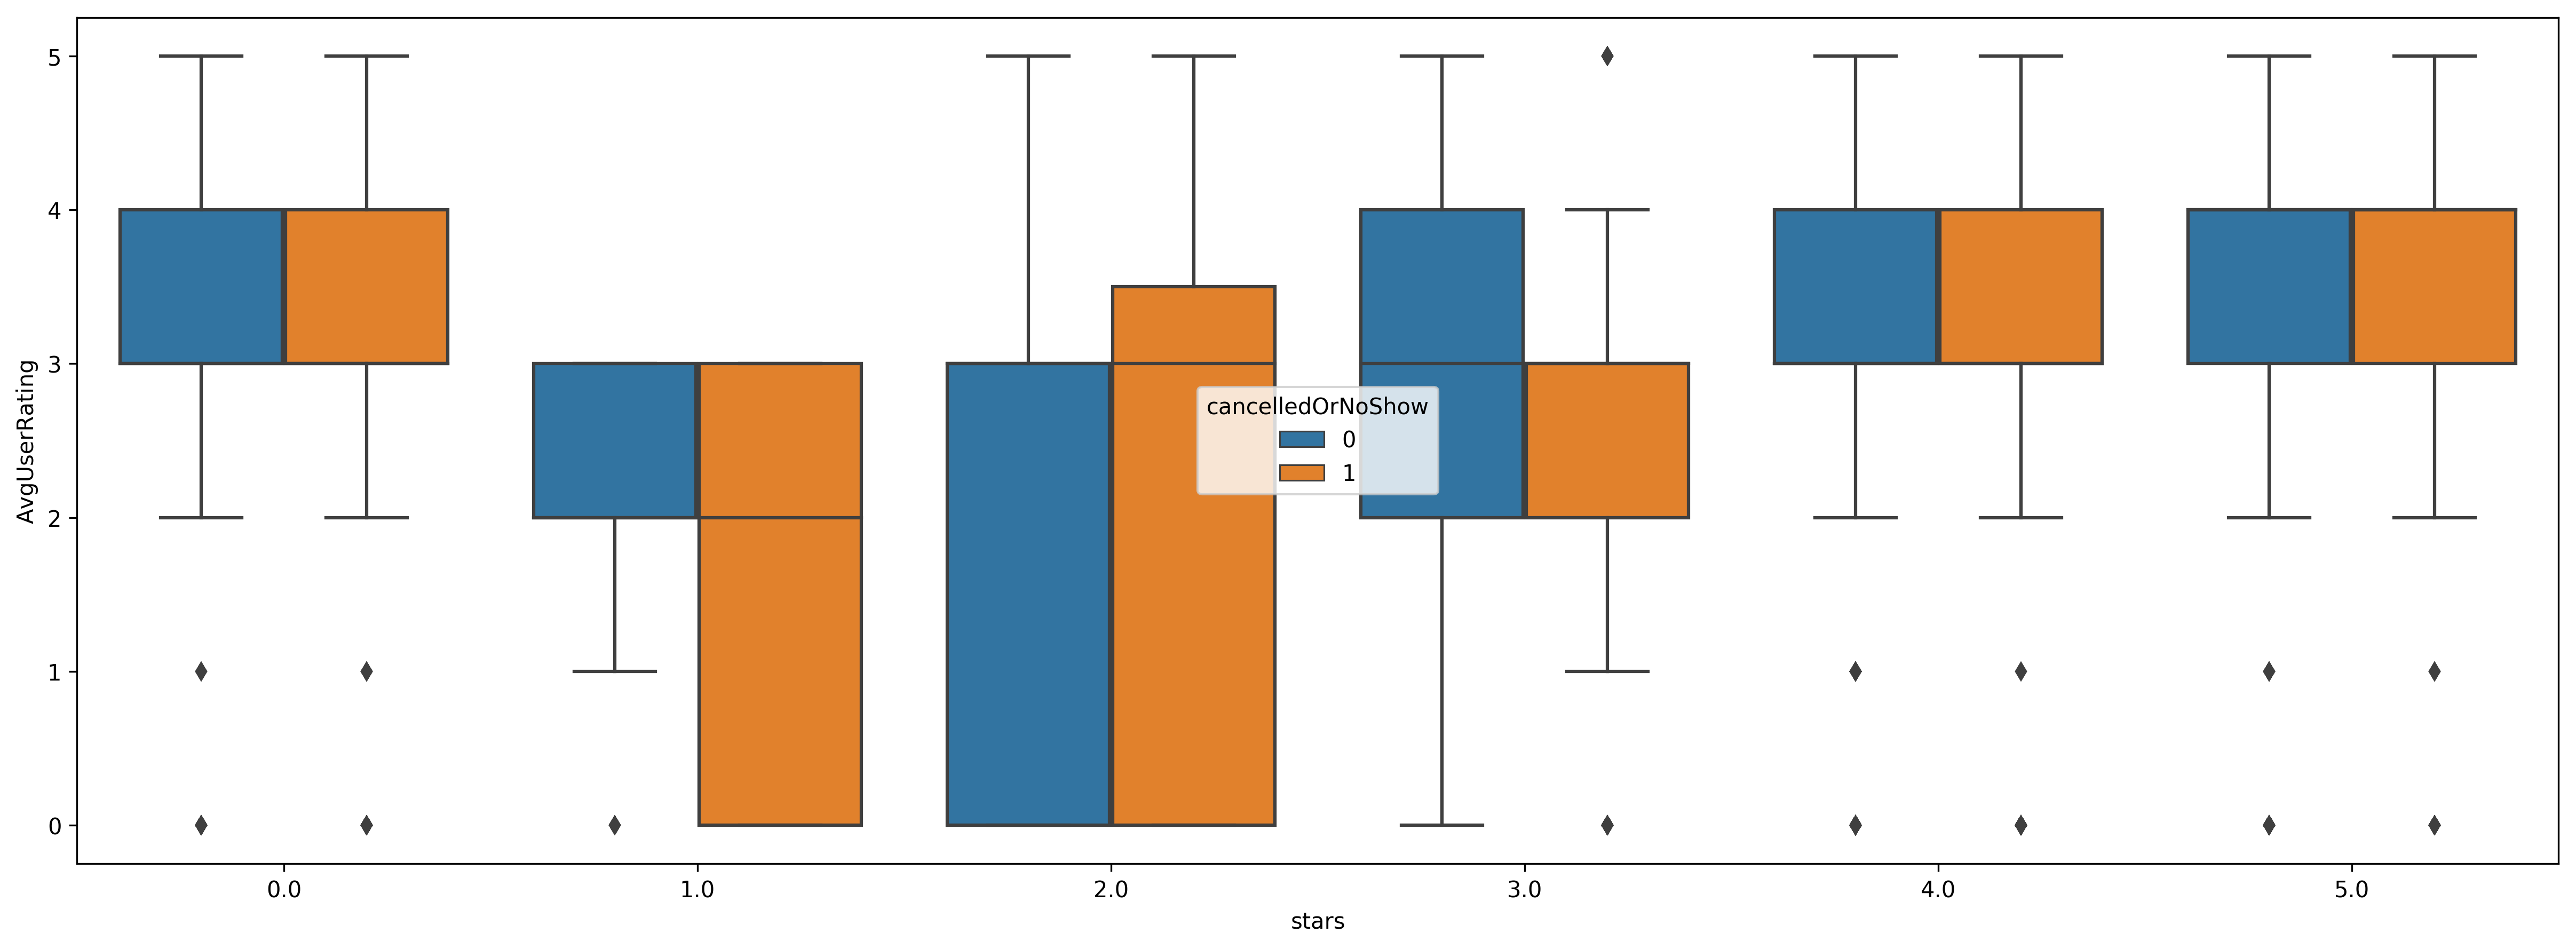

In [46]:
plt.figure(figsize=(20,7), dpi=300)
sns.boxplot(x='stars', y='AvgUserRating', hue= 'cancelledOrNoShow', data=df)
plt.show()

#### We see that users tend to cancel more based on bad reviews from previous guests

## Looks like unrated hotels are mostly 4 star hotels

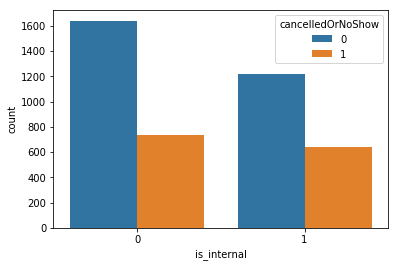

In [47]:
sns.countplot(x='is_internal', hue='cancelledOrNoShow', data=df)
plt.show()

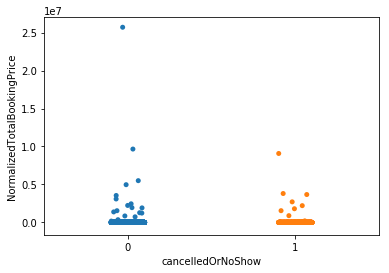

In [48]:
sns.stripplot(x="cancelledOrNoShow", y="NormalizedTotalBookingPrice", data=df);

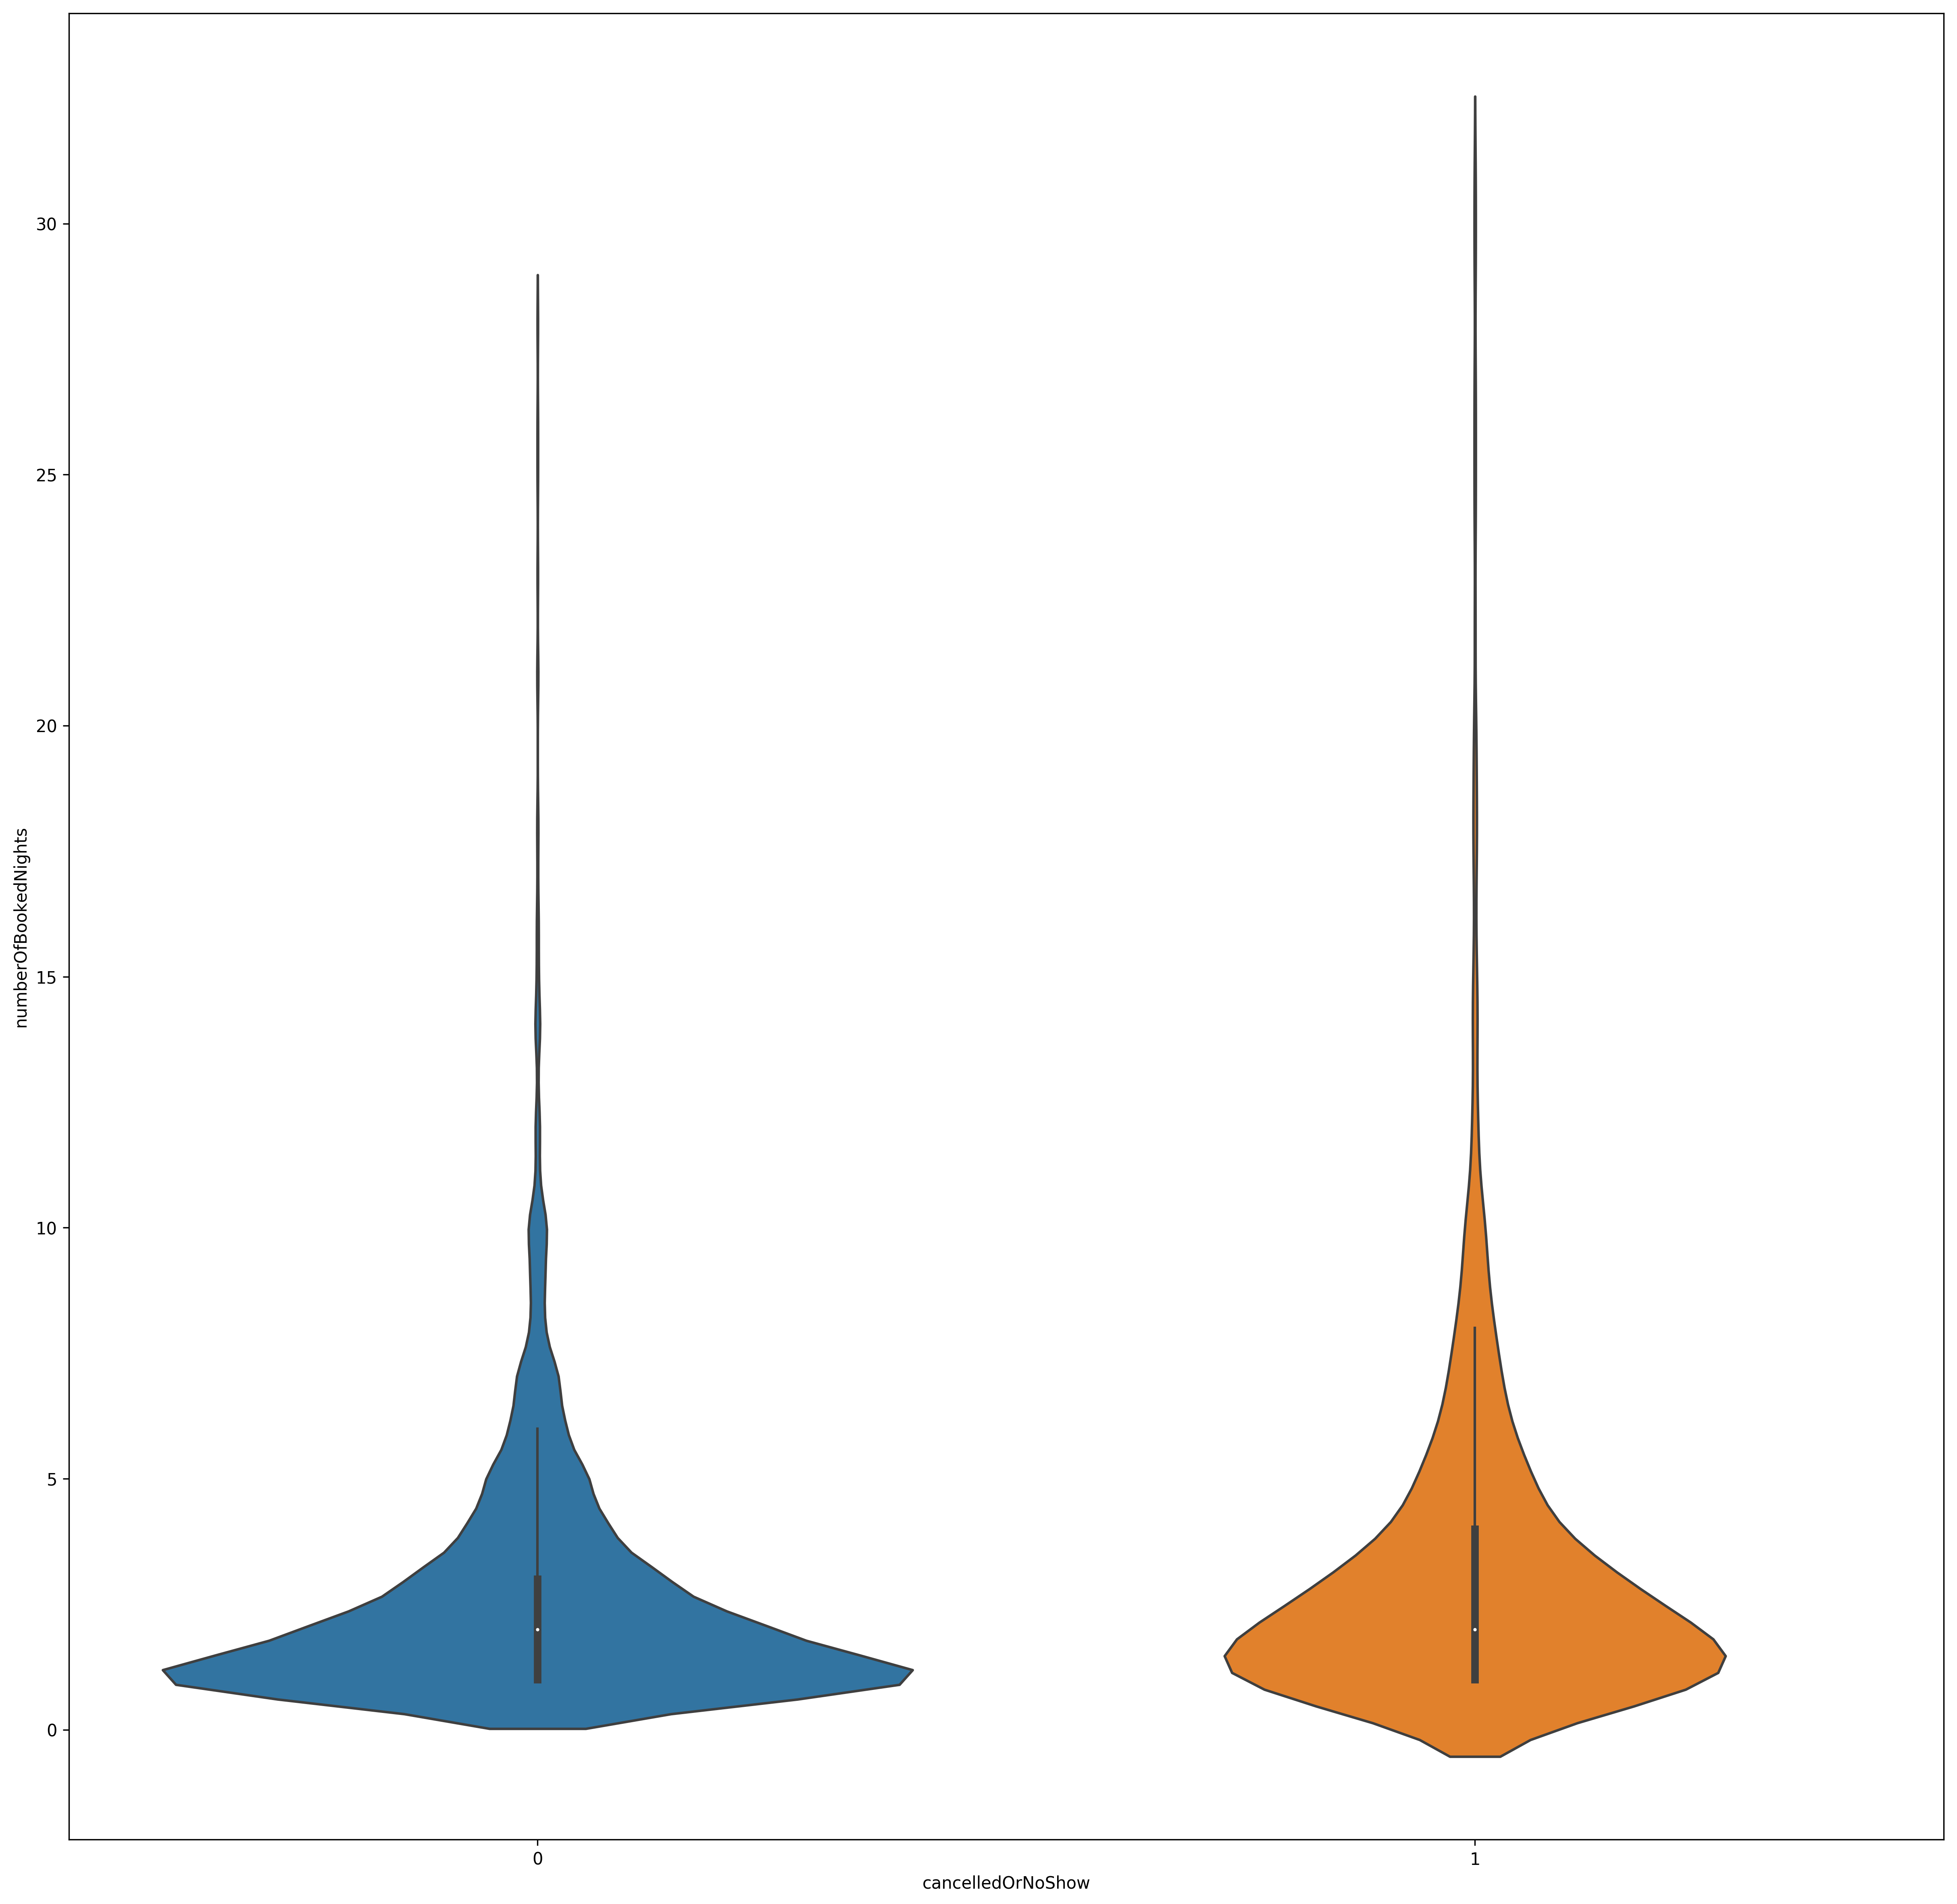

In [49]:
plt.figure(figsize=(20,20), dpi=300)
sns.violinplot(x="cancelledOrNoShow", y="numberOfBookedNights", data=df, split=True);

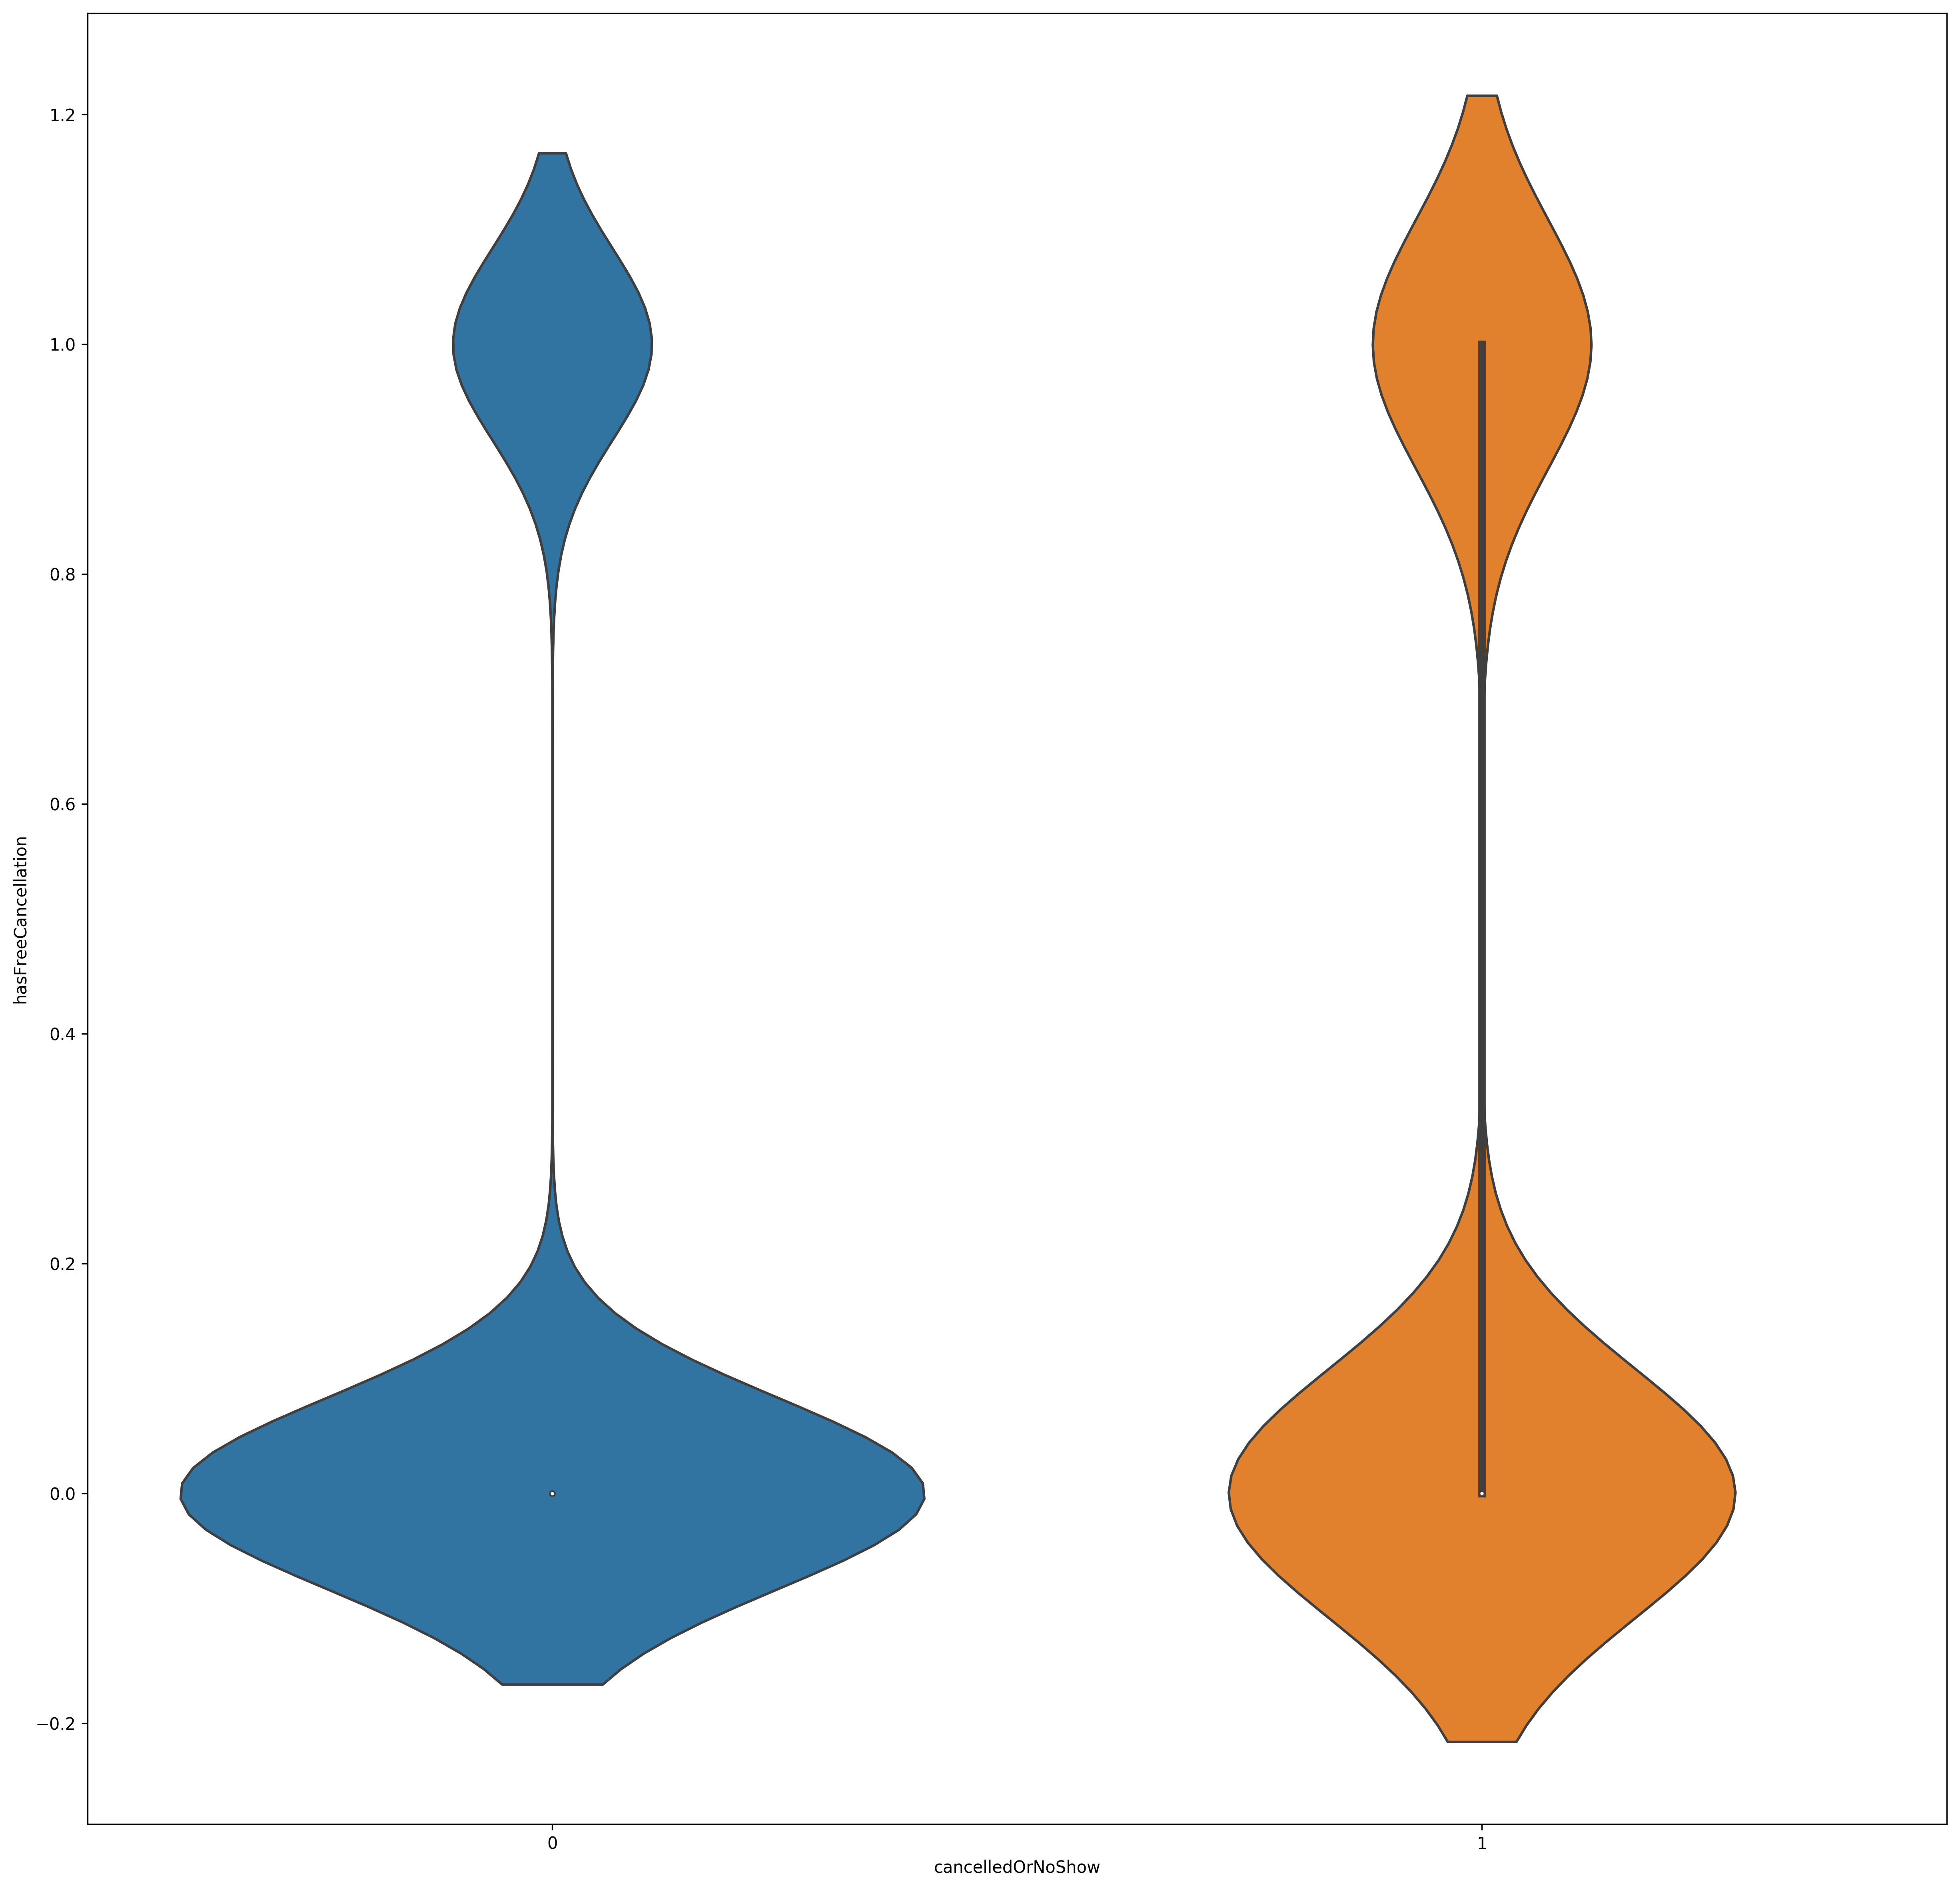

In [50]:
plt.figure(figsize=(20,20), dpi=300)
#axis(side=1,at=1:19)
sns.violinplot(x="cancelledOrNoShow", y="hasFreeCancellation", data=df, split=True);

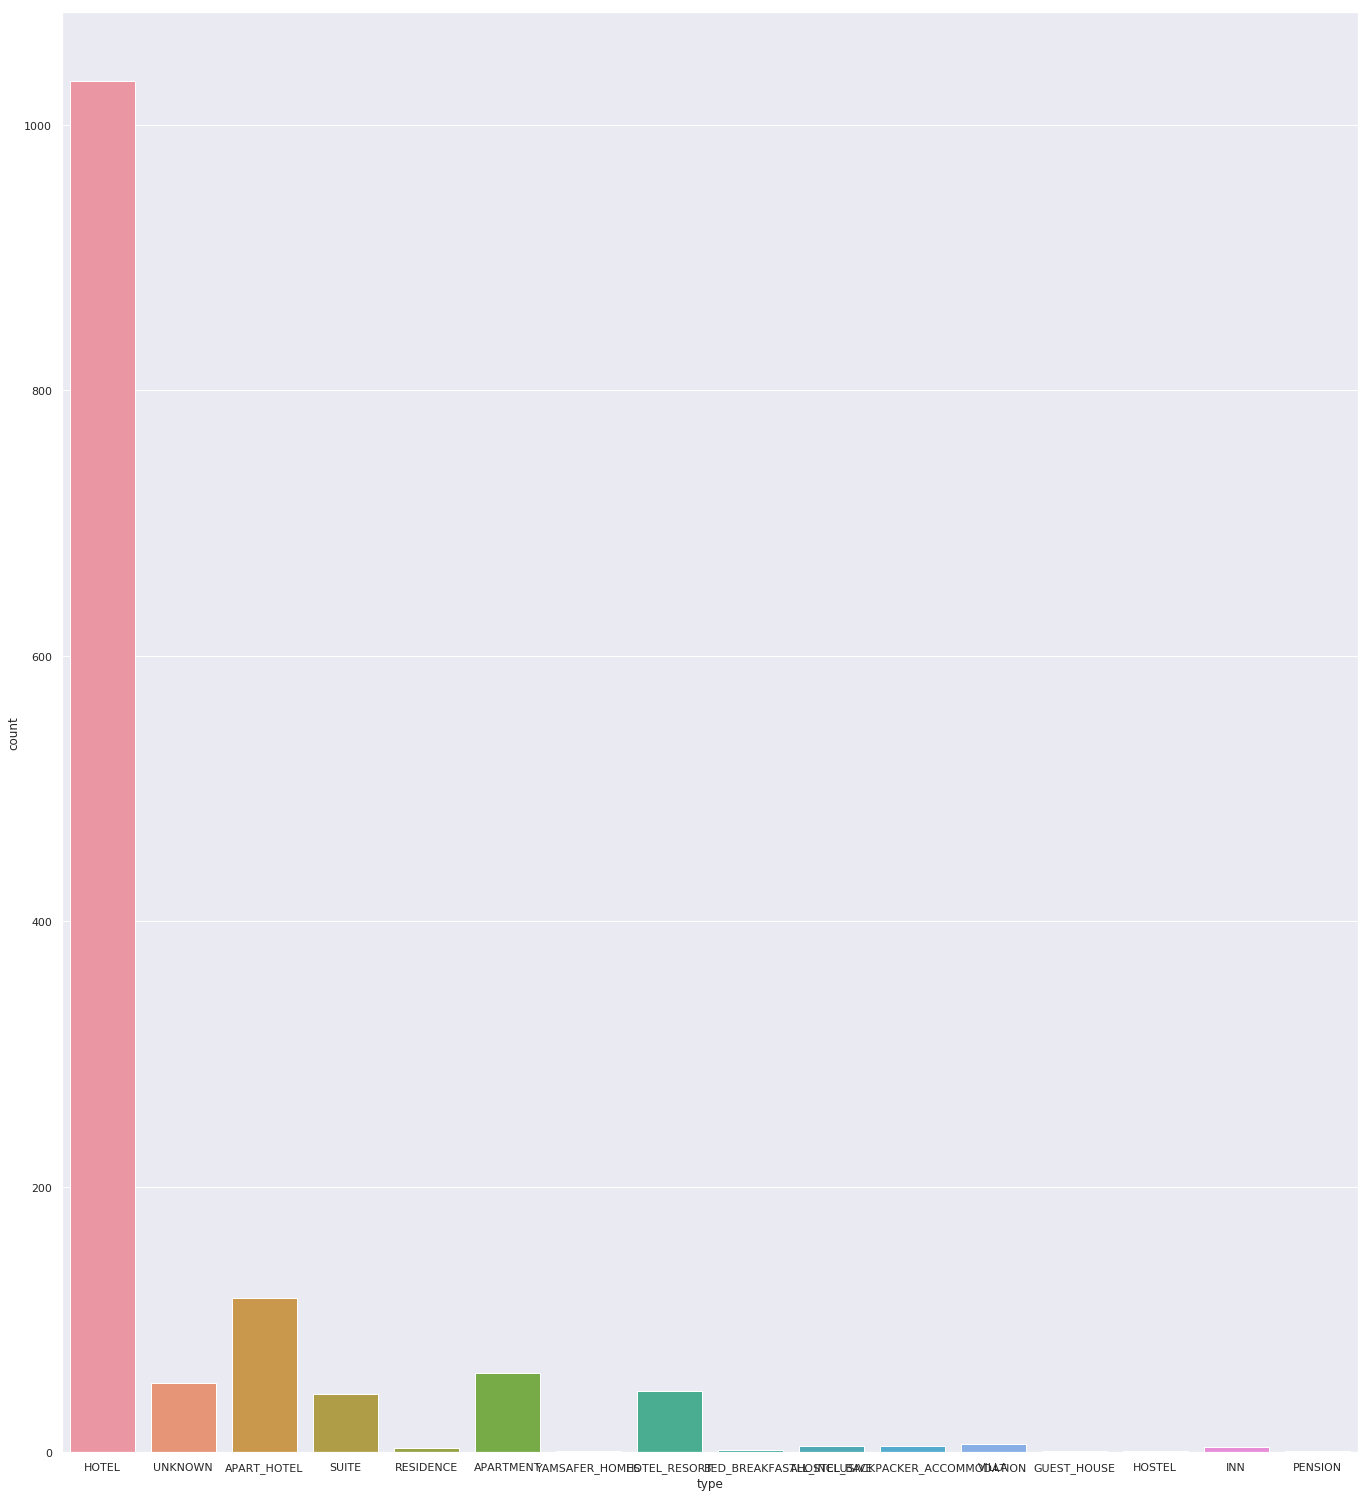

In [51]:
sns.set()
ax2 = plt.axes([0, 2, 3, 5])
sns.countplot(x='type', data=cancelled_orders)
plt.show()

## Factorize by Property Type

In [0]:
labels, levels = pd.factorize(df['type'])
df['type']= labels

#labels, levels = pd.factorize(df_feat['type'])
#df_feat['type']= labels

## Finding Correlations

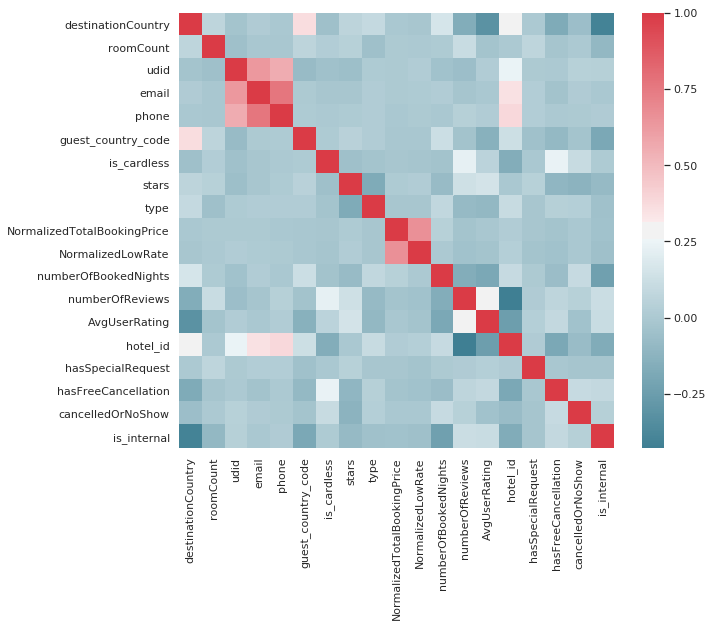

In [53]:
import seaborn as sns
sns.set()
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [54]:
df.columns

Index(['destinationCountry', 'roomCount', 'udid', 'email', 'phone',
       'guest_country_code', 'is_cardless', 'stars', 'type',
       'NormalizedTotalBookingPrice', 'NormalizedLowRate',
       'numberOfBookedNights', 'numberOfReviews', 'AvgUserRating', 'hotel_id',
       'hasSpecialRequest', 'hasFreeCancellation', 'cancelledOrNoShow',
       'is_internal'],
      dtype='object')

## Create features and targets

In [0]:
df_target        = df['cancelledOrNoShow']
df_feat_all      = df.drop(['cancelledOrNoShow'], axis=1)
df_feat_selected = df[['is_cardless', 'numberOfBookedNights', 'hasFreeCancellation', 'hasSpecialRequest']]

# Machine Learning:

## Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

### Run logistic regression using all features

In [0]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df_feat_all,df['cancelledOrNoShow'],test_size=0.30, random_state=101)

In [59]:
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

logreg.score(X_test, Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



0.6907946498819827

### Run logistic regression using selected features that are correlated

In [0]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df_feat_selected,df['cancelledOrNoShow'],test_size=0.30, random_state=101)

In [62]:
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

logreg.score(X_test, Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



0.6671911880409127

## Conclusion: 
We see that all features showed greater precision than selected features

# SVM 

### Definig Features and Targets

In [0]:
df_target = df['cancelledOrNoShow']
#Setting the features
df_feat_all      = df.drop(['cancelledOrNoShow'], axis=1)
df_feat_selected = df[['is_cardless', 'numberOfBookedNights', 'hasFreeCancellation', 'hasSpecialRequest']]

In [65]:
df_feat_all.head()

,destinationCountry,roomCount,udid,email,phone,guest_country_code,is_cardless,stars,type,NormalizedTotalBookingPrice,NormalizedLowRate,numberOfBookedNights,numberOfReviews,AvgUserRating,hotel_id,hasSpecialRequest,hasFreeCancellation,is_internal
0,0,1.0,0,0,0,0,0,4.0,0,229.0,166.0,1,103.0,4.0,0,0,1,1
1,1,2.0,1,1,1,0,0,1.0,0,126.0,90.0,2,10.0,1.0,1,0,0,0
2,2,1.0,2,2,2,0,0,5.0,0,1722.0,753.0,4,25.0,4.0,2,1,0,0
3,0,1.0,3,3,3,1,0,4.0,1,685.0,373.0,2,16.0,4.0,3,0,0,0
4,2,1.0,0,4,4,2,0,5.0,0,427.0,401.0,1,10.0,5.0,4,0,0,1


### Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_feat_all, np.ravel(df_target), test_size=0.30, random_state=101)

### Train the Support Vector Classifier

In [0]:
from sklearn.svm import SVC

In [0]:
#Use sigmoid kernel since it is logistic regression
model = SVC(kernel='sigmoid')

In [70]:
model.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

### Predictions and Evaluations

In [0]:
predictions = model.predict(X_test)

In [0]:
from sklearn.metrics import classification_report,confusion_matrix

In [73]:
print(confusion_matrix(y_test,predictions))

[[863   0]
 [408   0]]


In [74]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81       863
           1       0.00      0.00      0.00       408

    accuracy                           0.68      1271
   macro avg       0.34      0.50      0.40      1271
weighted avg       0.46      0.68      0.55      1271



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



## Use selected features

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_feat_selected, np.ravel(df_target), test_size=0.30, random_state=101)

In [76]:
model.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
predictions = model.predict(X_test)

In [78]:
print(confusion_matrix(y_test,predictions))

[[531 332]
 [284 124]]


In [79]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.65      0.62      0.63       863
           1       0.27      0.30      0.29       408

    accuracy                           0.52      1271
   macro avg       0.46      0.46      0.46      1271
weighted avg       0.53      0.52      0.52      1271



### Looks like selected features gave better results than all features, still has very low accuracy

### Cross Validation

In [80]:
clf = svm.SVC()
clf.fit(df_feat_selected, np.ravel(df_target))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [83]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, df_feat_selected, np.ravel(df_target), cv=5, scoring='accuracy').mean()

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set ga

0.6746162927981111

### More attempts

In [84]:
# note the scale of gamma and C
clf = svm.SVC(gamma=0.01, C=2)
cross_val_score(clf, df_feat_selected, np.ravel(df_target), cv=5, scoring='accuracy').mean()

0.67556080283353

## Let's compare three SVMs with different kernels
 - Radial Bias Function (RBF)
 - Linear
 - Poly of degree 3

# Decision Trees

In [85]:
df.columns

Index(['destinationCountry', 'roomCount', 'udid', 'email', 'phone',
       'guest_country_code', 'is_cardless', 'stars', 'type',
       'NormalizedTotalBookingPrice', 'NormalizedLowRate',
       'numberOfBookedNights', 'numberOfReviews', 'AvgUserRating', 'hotel_id',
       'hasSpecialRequest', 'hasFreeCancellation', 'cancelledOrNoShow',
       'is_internal'],
      dtype='object')

In [0]:
new_df = df[['roomCount', 'destinationCountry', 'guest_country_code', 'stars', 'NormalizedTotalBookingPrice', 'cancelledOrNoShow']]

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



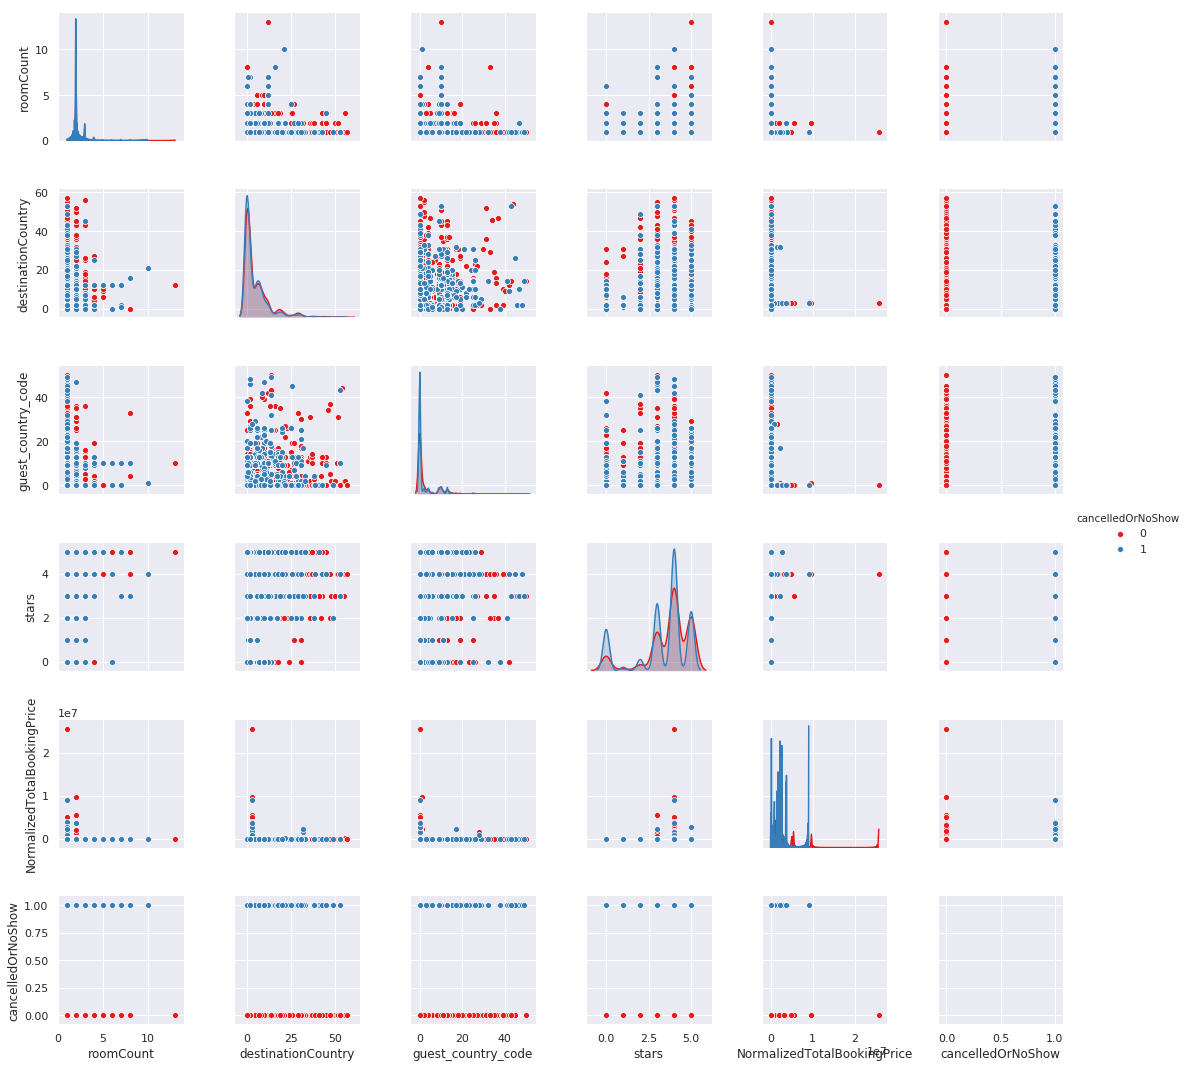

In [87]:
sns.pairplot(new_df,hue='cancelledOrNoShow',palette='Set1')

### Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_feat_all, np.ravel(df_target), test_size=0.30, random_state=101)

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
dtree = DecisionTreeClassifier()

In [92]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Prediction and Evaluation

In [0]:
predictions = dtree.predict(X_test)

In [0]:
from sklearn.metrics import classification_report,confusion_matrix

In [95]:
print(confusion_matrix(y_test,predictions))

[[604 259]
 [248 160]]


In [96]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.71      0.70      0.70       863
           1       0.38      0.39      0.39       408

    accuracy                           0.60      1271
   macro avg       0.55      0.55      0.55      1271
weighted avg       0.60      0.60      0.60      1271



## Try with selected features

In [0]:
df_feat_selected = df[['is_cardless', 'hasFreeCancellation', 'hasSpecialRequest', 'destinationCountry', 'stars', 'type']]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_feat_selected, np.ravel(df_target), test_size=0.30, random_state=101)

In [99]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
predictions = dtree.predict(X_test)

In [101]:
print(confusion_matrix(y_test,predictions))

[[747 116]
 [315  93]]


In [102]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.70      0.87      0.78       863
           1       0.44      0.23      0.30       408

    accuracy                           0.66      1271
   macro avg       0.57      0.55      0.54      1271
weighted avg       0.62      0.66      0.62      1271



# Random Forests

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_feat_all, np.ravel(df_target), test_size=0.30, random_state=101)

In [104]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=4)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rfc_pred = rfc.predict(X_test)

In [106]:
print(confusion_matrix(y_test,rfc_pred))

[[752 111]
 [330  78]]


In [107]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.70      0.87      0.77       863
           1       0.41      0.19      0.26       408

    accuracy                           0.65      1271
   macro avg       0.55      0.53      0.52      1271
weighted avg       0.60      0.65      0.61      1271



### Using selected features

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_feat_selected, np.ravel(df_target), test_size=0.30, random_state=101)

In [109]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=4)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rfc_pred = rfc.predict(X_test)

In [111]:
print(confusion_matrix(y_test,rfc_pred))

[[699 164]
 [297 111]]


In [112]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       863
           1       0.40      0.27      0.33       408

    accuracy                           0.64      1271
   macro avg       0.55      0.54      0.54      1271
weighted avg       0.61      0.64      0.61      1271



# KNN

## Standardize the Variables

In [113]:
df.columns

Index(['destinationCountry', 'roomCount', 'udid', 'email', 'phone',
       'guest_country_code', 'is_cardless', 'stars', 'type',
       'NormalizedTotalBookingPrice', 'NormalizedLowRate',
       'numberOfBookedNights', 'numberOfReviews', 'AvgUserRating', 'hotel_id',
       'hasSpecialRequest', 'hasFreeCancellation', 'cancelledOrNoShow',
       'is_internal'],
      dtype='object')

In [0]:
df_target = df['cancelledOrNoShow']

#Setting the features
df_feat_all      = df.drop(['cancelledOrNoShow'], axis=1)
df_feat_selected = df[['is_cardless', 'hasFreeCancellation', 'hasSpecialRequest', 'destinationCountry', 'stars', 'type']]

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
scaler = StandardScaler()

In [0]:
scaler.fit(df_feat_all)
scaled_features = scaler.transform(df_feat_all)

## Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features,df['cancelledOrNoShow'],
                                                    test_size=0.30)

## Using KNN (K=1)

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
knn = KNeighborsClassifier(n_neighbors=1)

In [122]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [0]:
pred = knn.predict(X_test)

## Predictions and Evaluations

In [124]:
print(confusion_matrix(y_test,pred))

[[598 241]
 [297 135]]


In [125]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69       839
           1       0.36      0.31      0.33       432

    accuracy                           0.58      1271
   macro avg       0.51      0.51      0.51      1271
weighted avg       0.56      0.58      0.57      1271



In [126]:
# NOW WITH K=10
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=10')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=10


[[782  57]
 [386  46]]


              precision    recall  f1-score   support

           0       0.67      0.93      0.78       839
           1       0.45      0.11      0.17       432

    accuracy                           0.65      1271
   macro avg       0.56      0.52      0.48      1271
weighted avg       0.59      0.65      0.57      1271



## Using selected values

In [0]:
scaler.fit(df_feat_selected)
scaled_features_selected = scaler.transform(df_feat_selected)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features_selected,df['cancelledOrNoShow'],
                                                    test_size=0.30)

In [0]:
knn = KNeighborsClassifier(n_neighbors=25)

In [130]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

In [0]:
pred = knn.predict(X_test)

In [132]:
print(confusion_matrix(y_test,pred))

[[787  62]
 [371  51]]


In [133]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.68      0.93      0.78       849
           1       0.45      0.12      0.19       422

    accuracy                           0.66      1271
   macro avg       0.57      0.52      0.49      1271
weighted avg       0.60      0.66      0.59      1271



# *Neural Network*

In [134]:
df.columns

Index(['destinationCountry', 'roomCount', 'udid', 'email', 'phone',
       'guest_country_code', 'is_cardless', 'stars', 'type',
       'NormalizedTotalBookingPrice', 'NormalizedLowRate',
       'numberOfBookedNights', 'numberOfReviews', 'AvgUserRating', 'hotel_id',
       'hasSpecialRequest', 'hasFreeCancellation', 'cancelledOrNoShow',
       'is_internal'],
      dtype='object')

In [135]:
df_feat = df.drop(['udid', 'phone', 'email', 'cancelledOrNoShow', 'hotel_id', 'type'], axis=1)

df_feat.head()

,destinationCountry,roomCount,guest_country_code,is_cardless,stars,NormalizedTotalBookingPrice,NormalizedLowRate,numberOfBookedNights,numberOfReviews,AvgUserRating,hasSpecialRequest,hasFreeCancellation,is_internal
0,0,1.0,0,0,4.0,229.0,166.0,1,103.0,4.0,0,1,1
1,1,2.0,0,0,1.0,126.0,90.0,2,10.0,1.0,0,0,0
2,2,1.0,0,0,5.0,1722.0,753.0,4,25.0,4.0,1,0,0
3,0,1.0,1,0,4.0,685.0,373.0,2,16.0,4.0,0,0,0
4,2,1.0,2,0,5.0,427.0,401.0,1,10.0,5.0,0,0,1


In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_feat, np.ravel(df_target), test_size=0.30, random_state=101)

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
scaler = StandardScaler()

In [139]:
# Fit only to the training data
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [140]:
StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Training the model

In [0]:
from sklearn.neural_network import MLPClassifier

In [0]:
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)

In [144]:
mlp.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [145]:
MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

## Predictions and Evaluation

In [0]:
predictions = mlp.predict(X_test)

In [0]:
from sklearn.metrics import classification_report,confusion_matrix

In [148]:
print(confusion_matrix(y_test,predictions))

[[731 132]
 [306 102]]


In [149]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77       863
           1       0.44      0.25      0.32       408

    accuracy                           0.66      1271
   macro avg       0.57      0.55      0.54      1271
weighted avg       0.62      0.66      0.62      1271



# More Attempts
## We are going to merge columns together to create new features

In [0]:
new_df = df
new_df['Review_Rating']=df['AvgUserRating']*df['numberOfReviews']

In [151]:
new_df.head()

,destinationCountry,roomCount,udid,email,phone,guest_country_code,is_cardless,stars,type,NormalizedTotalBookingPrice,NormalizedLowRate,numberOfBookedNights,numberOfReviews,AvgUserRating,hotel_id,hasSpecialRequest,hasFreeCancellation,cancelledOrNoShow,is_internal,Review_Rating
0,0,1.0,0,0,0,0,0,4.0,0,229.0,166.0,1,103.0,4.0,0,0,1,0,1,412.0
1,1,2.0,1,1,1,0,0,1.0,0,126.0,90.0,2,10.0,1.0,1,0,0,1,0,10.0
2,2,1.0,2,2,2,0,0,5.0,0,1722.0,753.0,4,25.0,4.0,2,1,0,1,0,100.0
3,0,1.0,3,3,3,1,0,4.0,1,685.0,373.0,2,16.0,4.0,3,0,0,0,0,64.0
4,2,1.0,0,4,4,2,0,5.0,0,427.0,401.0,1,10.0,5.0,4,0,0,0,1,50.0


In [0]:
new_df_feat = new_df.drop(['cancelledOrNoShow', 'type', 'phone'],axis=1)
X_train1, X_test1, Y_train1, Y_test1 = sklearn.model_selection.train_test_split(new_df_feat, new_df['cancelledOrNoShow'],test_size=0.30, random_state=101)

In [154]:
rfc = RandomForestClassifier(n_estimators=4)
rfc.fit(X_train1, Y_train1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [155]:
rfc_pred = rfc.predict(X_test1)
print(confusion_matrix(rfc_pred,Y_test1))
print(classification_report(rfc_pred,Y_test1))

[[748 319]
 [115  89]]
              precision    recall  f1-score   support

           0       0.87      0.70      0.78      1067
           1       0.22      0.44      0.29       204

    accuracy                           0.66      1271
   macro avg       0.54      0.57      0.53      1271
weighted avg       0.76      0.66      0.70      1271



## Try more stuff:
### Add "Room_Nights" Column to DF

In [0]:
new_df['Room_Nights']=df['roomCount']*df['numberOfBookedNights']

In [157]:
new_df.head()

,destinationCountry,roomCount,udid,email,phone,guest_country_code,is_cardless,stars,type,NormalizedTotalBookingPrice,NormalizedLowRate,numberOfBookedNights,numberOfReviews,AvgUserRating,hotel_id,hasSpecialRequest,hasFreeCancellation,cancelledOrNoShow,is_internal,Review_Rating,Room_Nights
0,0,1.0,0,0,0,0,0,4.0,0,229.0,166.0,1,103.0,4.0,0,0,1,0,1,412.0,1.0
1,1,2.0,1,1,1,0,0,1.0,0,126.0,90.0,2,10.0,1.0,1,0,0,1,0,10.0,4.0
2,2,1.0,2,2,2,0,0,5.0,0,1722.0,753.0,4,25.0,4.0,2,1,0,1,0,100.0,4.0
3,0,1.0,3,3,3,1,0,4.0,1,685.0,373.0,2,16.0,4.0,3,0,0,0,0,64.0,2.0
4,2,1.0,0,4,4,2,0,5.0,0,427.0,401.0,1,10.0,5.0,4,0,0,0,1,50.0,1.0


## Check Heatmap after adding more columns

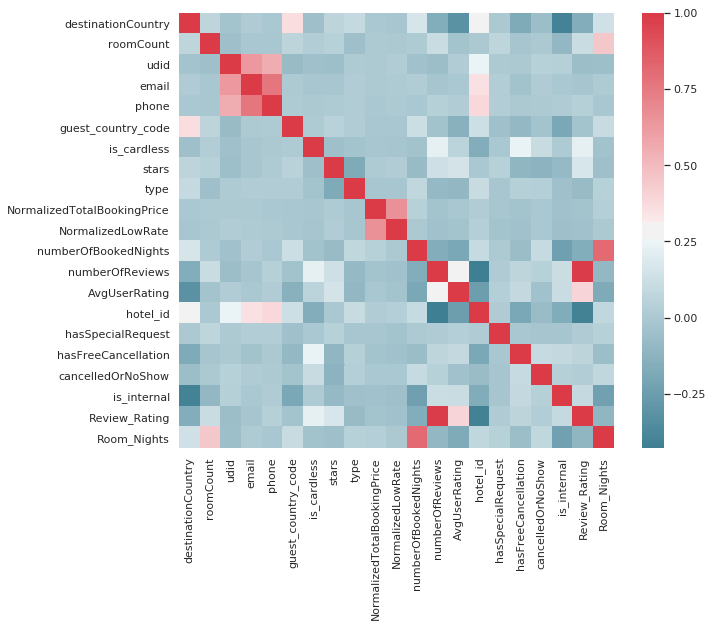

In [158]:
import seaborn as sns
sns.set()
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
corr = new_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## Apply Random Forest Classifier on the new dataframe with the new columns

In [0]:
new_df_feat = new_df[['is_cardless', 'numberOfBookedNights', 'hasFreeCancellation', 'Room_Nights']]
X_train1, X_test1, Y_train1, Y_test1 = sklearn.model_selection.train_test_split(new_df_feat, new_df['cancelledOrNoShow'],test_size=0.30, random_state=101)

In [161]:
rfc = RandomForestClassifier(n_estimators=5)
rfc.fit(X_train1, Y_train1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [162]:
rfc_pred = rfc.predict(X_test1)
print(confusion_matrix(rfc_pred,Y_test1))
print(classification_report(rfc_pred,Y_test1))

[[815 368]
 [ 48  40]]
              precision    recall  f1-score   support

           0       0.94      0.69      0.80      1183
           1       0.10      0.45      0.16        88

    accuracy                           0.67      1271
   macro avg       0.52      0.57      0.48      1271
weighted avg       0.89      0.67      0.75      1271



# 92% Precision, cool ! Now we're at 88, not bad also..

# Conclusion:
### After trying multiple machine learning algorithms we found out that having good models is only as good as the data you feed it as shown by how the model improved drastically after adding 3 columns to the data set that helped find new correlations

# Future Work:
1. Add booknig window column (difference between time of booking and checkin time)
2. Add poltical situation column that specifies political status in destination country
3. Add naive bayes classifier
4. Add Graphiz for decision tree
5. Reasons for selecting machine learning models
6. Deploy model as an API to be used for Business needs
7. Make model learn from new sets
 